# 항만 체류 시간 예측 프로젝트

### 프로젝트 개요

항만은 글로벌 공급망과 국가 간 무역의 핵심 거점으로, 선박의 입항부터 출항까지의 체류 시간은 항만의 운영 효율성과 해운 기업의 정시 운항 능력에 직결되는 중요한 지표입니다.

특히 항만 내 선박 체류 시간은 터미널 혼잡도, 선석 배정의 효율성, 하역 인력 운영 등 다양한 물류 흐름과 운영 비용에 영향을 미치며, 해운사의 수익성과 고객 만족도에도 간접적인 영향을 줍니다.

이번 프로젝트에서는 해양수산부의 Port-MIS 입출항 데이터를 기반으로, 개별 선박의 입항 및 출항 정보, 선박 제원, 항만 및 기항지 정보를 활용하여 항만 내 선박 체류 시간을 예측하는 머신러닝 회귀 모델을 구축하고 성능을 평가합니다.


### 목표

- 선박 및 항만 관련 입출항 데이터를 기반으로, 항만 체류 시간(시간 단위)을 예측하는 회귀 모델을 개발

- 모델 성능은 MSE, R² 평가 지표를 통해 측정 및 비교

- 적재화물명, 적재톤수, 총톤수 등의 범주형/수치형 정보를 활용

- 체계적인 전처리(결측값 제거, 이상치 필터링, 인코딩 등) 및 파생 변수 생성 과정을 수행

- 모델 해석을 통해 체류 시간에 영향을 미치는 핵심 요인들을 분석

- 전처리 및 피처 엔지니어링을 통해 머신러닝 성능 향상을 위한 구조적 접근 진행


### 데이터 출처

해양수산부_해운항만물류정보_한중일물류 입출항정보_20240731.csv : [해양수산부 해운항만물류정보 한중일물류 입출항정보](https://www.data.go.kr/data/15133162/fileData.do) 


---

## 목차
1. 데이터 불러오기
2. 탐색적 데이터 분석 (EDA)
3. 데이터 전처리
4. 체류 시간 예측 회귀 모델
5. 모델 검증



## 1. 데이터 불러오기 

이번 프로젝트에서 필요한 라이브러리를 불러옵니다.

In [532]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm


# 깔끔한 출력을 위한 설정
import warnings

warnings.filterwarnings("ignore")  # 기술적 경고 숨기기

# 한글 폰트 설정
plt.rc("font", family="NanumGothic")
plt.rcParams["axes.unicode_minus"] = False

먼저 데이터를 확인해 볼까요?

In [533]:
# 데이터 불러오기
df = pd.read_csv(
    "해양수산부_해운항만물류정보_한중일물류 입출항정보_20240731.csv",
    encoding="cp949",
)
#######################################################################################################################################
'''
공공기관은 windows를 많이 사용
Windows의 기본 한글 인코딩은 **"CP949" (또는 "euc-kr")**.
그래서 엑셀, 한글, 텍스트 파일을 저장하거나 CSV로 내보낼 때 자동으로 "cp949" 인코딩이 적용되는 경우가 많아.
utf-8로 열면? UnicodeDecodeError 발생 가능성 높음.
이는 CP949로 인코딩된 바이트가 UTF-8에서는 유효하지 않은 시퀀스로 해석되기 때문.
cp949 이점
CP949는 Windows의 기본 한글 인코딩이기 때문에 엑셀에서 열었을 때 한글이 깨지지 않음
'''
#######################################################################################################################################
# 데이터 크기 확인

print("데이터 shape:", df.shape)
print("\n 데이터의 상위 5행 : ")
print(df.head())

데이터 shape: (14063, 28)

 데이터의 상위 5행 : 
  항구청코드 입출항구분    호출부호  입항년도  입항횟수                 신고일시      계선시설명 적재화물명  \
0    부산    입항    UEPG  2024     1  2024-09-09 09:55:45  남외항 N-3박지  해당없음   
1    부산    입항    UEPG  2024     2  2024-09-09 09:56:00  남외항 N-3박지    기타   
2    완도    입항  HP5145  2024     3  2024-07-05 16:24:58       검역묘지  해당없음   
3    완도    출항  HP5145  2024     3  2024-07-05 16:41:50       검역묘지  해당없음   
4    부산    입항    UEPG  2024     3  2024-09-09 09:56:49  남외항 N-3박지    기타   

     적재톤수  환적톤수  ...                입출항일시  입항목적명  전출항지국가명     전출항지항구명 차항지국가명  \
0     0.0   0.0  ...  2024-01-18 00:15:00   단순경유       중국   XIAMEN PT    러시아   
1  1270.0   0.0  ...  2024-03-07 11:25:00   단순경유       중국     QINGDAO    러시아   
2     0.0   0.0  ...  2024-03-22 20:35:00     기타     대한민국          여수     중국   
3     0.0   0.0  ...  2024-03-23 05:20:00    NaN      NaN         NaN     중국   
4  5001.0   0.0  ...  2024-04-10 08:00:00   단순경유       중국  TIANJIN PT    러시아   

      차항지항구명 목적지국가명     목적지항구

In [534]:
df

,항구청코드,입출항구분,호출부호,입항년도,입항횟수,신고일시,계선시설명,적재화물명,적재톤수,환적톤수,...,입출항일시,입항목적명,전출항지국가명,전출항지항구명,차항지국가명,차항지항구명,목적지국가명,목적지항구명,등록일시,수정일시
0,부산,입항,UEPG,2024,1,2024-09-09 09:55:45,남외항 N-3박지,해당없음,0.0,0.0,...,2024-01-18 00:15:00,단순경유,중국,XIAMEN PT,러시아,NAKHODKA,NaN,NaN,2024-01-16 11:27:12,2024-09-09 10:01:46
1,부산,입항,UEPG,2024,2,2024-09-09 09:56:00,남외항 N-3박지,기타,1270.0,0.0,...,2024-03-07 11:25:00,단순경유,중국,QINGDAO,러시아,NAKHODKA,NaN,NaN,2024-03-05 09:52:38,2024-09-09 10:02:10
2,완도,입항,HP5145,2024,3,2024-07-05 16:24:58,검역묘지,해당없음,0.0,0.0,...,2024-03-22 20:35:00,기타,대한민국,여수,중국,SHIDAO PT,NaN,NaN,2024-07-05 15:22:55,2024-07-07 10:36:45
3,완도,출항,HP5145,2024,3,2024-07-05 16:41:50,검역묘지,해당없음,0.0,0.0,...,2024-03-23 05:20:00,NaN,NaN,NaN,중국,SHIDAO PT,중국,SHIDAO PT,2024-07-05 16:28:56,2024-07-07 10:37:16
4,부산,입항,UEPG,2024,3,2024-09-09 09:56:49,남외항 N-3박지,기타,5001.0,0.0,...,2024-04-10 08:00:00,단순경유,중국,TIANJIN PT,러시아,NAKHODKA,NaN,NaN,2024-04-08 18:33:14,2024-09-09 10:02:54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14058,부산,출항,D7HC,2024,3,2024-08-11 14:10:06,신항 4부두 1선석,전기기기,8956.0,0.0,...,2024-08-10 23:06:00,NaN,NaN,NaN,중국,SHANGHAI,홍콩,HONG KONG,2024-07-31 04:44:34,2024-08-12 09:42:16
14059,부산,입항,D7XP,2024,26,2024-08-13 14:30:39,자성대부두 64선석,잡품,3328.0,1472.0,...,2024-08-13 13:12:00,양적하,일본,KANAZAWA,대한민국,광양,NaN,NaN,2024-07-26 11:16:32,2024-08-14 11:02:04
14060,여수,출항,V7IH9,2024,1,2024-08-14 10:08:06,정박지D-1구역,해당없음,0.0,0.0,...,2024-08-14 01:47:00,NaN,NaN,NaN,중국,LANSHAN PT,중국,LANSHAN PT,2024-07-19 11:13:19,2024-08-16 15:56:46
14061,부산,입항,BRWT,2024,1,2024-08-19 10:46:21,남외항 N-5박지,해당없음,0.0,0.0,...,2024-08-15 06:18:00,급유,중국,SHIDAO PT,캐나다,VANCOUVER,NaN,NaN,2024-07-27 16:46:56,2024-08-19 12:09:39


이 데이터에는 각 선박의 입항 및 출항 시각, 선박 제원, 입출항 항만 및 기항지 정보 등 다양한 항만 운영 및 선박 특성 관련 변수가 포함되어 있으며, 이러한 요소들은 항만 내 체류 시간에 영향을 미치는 핵심 요인으로 작용합니다. 이 변수들을 바탕으로 회귀 모델의 입력값을 구성하게 됩니다.

이 데이터에서 컬럼은 다음과 같습니다.

| 컬럼명         | 설명                               | 컬럼명         | 설명                               |
| ----------- | -------------------------------- | ----------- | -------------------------------- |
| **항구청코드**   | 입출항을 관리하는 관할 항만청의 고유 코드 (부산)     | **입출항구분**   | 해당 행이 입항인지 출항인지 구분 (입항, 출항)      |
| **호출부호**    | 선박의 무선 통신용 고유 식별 코드 (Call Sign)  | **입항년도**    | 선박이 입항한 연도                       |
| **입항횟수**    | 해당 연도에 선박이 입항한 누적 횟수             | **신고일시**    | 해당 입출항 신고가 이루어진 날짜 및 시각          |
| **계선시설명**   | 선박이 정박한 부두 또는 선석(계선시설)의 이름       | **적재화물명**   | 선박에 적재된 주요 화물의 이름 또는 종류          |
| **적재톤수**    | 선박에 실린 전체 화물의 무게 (톤 단위)          | **환적톤수**    | 다른 선박으로 환적 예정인 화물의 무게            |
| **양적하화물톤**  | 하역한 전체 화물의 무게 (톤 단위)             | **위험물톤수**   | 위험물로 분류된 화물의 무게 (톤 단위)           |
| **징수결정톤수**  | 항만 사용료나 하역료 등 부과 기준이 되는 톤수       | **총톤수**     | 선박의 총 내부 용적 (Gross Tonnage, G/T) |
| **내외항구분**   | 해당 선박이 내항(국내) 또는 외항(국제) 항로인지 구분  | **선박국적명**   | 선박이 등록된 국가명 (국적)                 |
| **선박종류명**   | 선박의 분류 (풀컨테이너선, 냉동.냉장선, 일반화물선 등) | **선박명**     | 선박의 이름                           |
| **입출항일시**   | 선박의 입항 또는 출항 시각 (입출항구분과 함께 해석)   | **입항목적명**   | 입항 목적 (하역, 승선, 연료 보급 등)          |
| **전출항지국가명** | 직전 출항지의 국가명                      | **전출항지항구명** | 직전 출항지의 항만 이름                    |
| **차항지국가명**  | 다음 기항 예정 국가명                     | **차항지항구명**  | 다음 기항 예정 항만 이름                   |
| **목적지국가명**  | 선박이 향하는 최종 목적지의 국가명              | **목적지항구명**  |                                  |

이렇게 이번 프로젝트에서 사용할 데이터들을 확인해보았습니다. 

이제부터는 탐색적 데이터 분석을 수행하며 데이터를 이해하고 어떻게 전처리할지 고민해 보도록 하겠습니다. 

## 2. 탐색적 데이터 분석 (EDA)

EDA는 모델 학습 전 데이터를 깊이 이해하는 과정으로, 변수 간의 관계, 분포, 결측값, 이상치 여부 등을 확인하는 데 필수적입니다.

우선 데이터의 데이터 타입과 분포를 확인해보겠습니다.

In [535]:
# 데이터프레임 컬럼 확인
df.columns

Index(['항구청코드', '입출항구분', '호출부호', '입항년도', '입항횟수', '신고일시', '계선시설명', '적재화물명',
       '적재톤수', '환적톤수', '양적하화물톤', '위험물톤수', '징수결정톤수', '총톤수', '내외항구분', '선박국적명',
       '선박종류명', '선박명', '입출항일시', '입항목적명', '전출항지국가명', '전출항지항구명', '차항지국가명',
       '차항지항구명', '목적지국가명', '목적지항구명', '등록일시', '수정일시'],
      dtype='object')

In [536]:
# 데이터 타입 및 결측치 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14063 entries, 0 to 14062
Data columns (total 28 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   항구청코드    14063 non-null  object 
 1   입출항구분    14063 non-null  object 
 2   호출부호     14063 non-null  object 
 3   입항년도     14063 non-null  int64  
 4   입항횟수     14063 non-null  int64  
 5   신고일시     14063 non-null  object 
 6   계선시설명    14063 non-null  object 
 7   적재화물명    14063 non-null  object 
 8   적재톤수     14063 non-null  float64
 9   환적톤수     14063 non-null  float64
 10  양적하화물톤   14063 non-null  float64
 11  위험물톤수    14063 non-null  float64
 12  징수결정톤수   14063 non-null  int64  
 13  총톤수      14063 non-null  float64
 14  내외항구분    14063 non-null  object 
 15  선박국적명    14063 non-null  object 
 16  선박종류명    14063 non-null  object 
 17  선박명      14063 non-null  object 
 18  입출항일시    14063 non-null  object 
 19  입항목적명    8081 non-null   object 
 20  전출항지국가명  8081 non-null   object 
 21  전출항지항구명  808

이 데이터셋은 총 28개의 컬럼으로 구성되어 있으며, 문자형(**object**) 변수와 수치형 변수(**float64**, **int64**)가 혼합된 구조입니다.

특히 `입출항구분`, `선박종류명`, `내외항구분`, `항만청코드` 등은 명목형 범주 변수로, 머신러닝 모델에 투입하기 전 반드시 인코딩 처리가 필요합니다.

또한 `입출항일시`, `신고일시`, `등록일시`, `수정일시` 등 날짜와 시간 정보를 포함하는 컬럼들은 **datetime** 형식으로 변환하여 사용할 수 있습니다.

반면, `적재톤수`, `총톤수`, `징수결정톤수` 등은 정량적인 수치형 변수로 그대로 사용할 수 있습니다.

### 2.1. 입출항 트렌드 분석

`입항년도`와 `입출항일시`를 기준으로 연도별, 월별 입출항량 변화 추이를 분석하겠습니다. 특정 계절 또는 기간에 입출항이 집중되는지 여부를 파악하는 과정입니다.

먼저 `pd.to_datetime()` 함수를 사용해 문자열(**string**) 형태로 저장된 `입출항일시` 정보를 **datetime** 자료형으로 변환합니다. 이렇게 변환된 값은 연도별, 월별, 시간대별 분석, 시간 차 계산(`체류시간`) 등의 시계열 분석이 가능합니다.

In [537]:

df["입출항일시"] = pd.to_datetime(df["입출항일시"], errors="coerce")
#######################################################################################################################################
# pd.to_datetime()은 문자열을 날짜(datetime) 타입으로 변환하는 함수인데, 문자열 값이 다음과 같은 경우에 문제가 생길 수 있어:
'''
"2024-13-01" → 존재하지 않는 달 (13월)
"abc" → 날짜 형식이 아님
"" → 빈 문자열
null, NaN
'''
# 이런 값들을 어떻게 처리할지 결정하는 게 errors 파라미터고, 3가지 값이 있어:
'''
"raise" (기본값)	오류 발생 시 예외(Exception) 발생함
"coerce"	오류 발생 시 NaT로 변환 (결측값 취급)
"ignore"	오류 무시하고 원래 문자열 그대로 반환 (파싱 X
'''
#######################################################################################################################################
df["입출항일시"]

0       2024-01-18 00:15:00
1       2024-03-07 11:25:00
2       2024-03-22 20:35:00
3       2024-03-23 05:20:00
4       2024-04-10 08:00:00
                ...        
14058   2024-08-10 23:06:00
14059   2024-08-13 13:12:00
14060   2024-08-14 01:47:00
14061   2024-08-15 06:18:00
14062   2024-08-25 16:12:00
Name: 입출항일시, Length: 14063, dtype: datetime64[ns]

입출항 시점을 연-월 단위로 그룹화하기 위해 새로운 컬럼 **입항연월**을 생성합니다.

**datetime** 자료형으로 변환한 `입출항일시` 컬럼을 `.dt.to_period("M")`를 사용하여 연-월(YYYY-MM) 형태의 Period 형식으로 변환합니다. 이 과정을 통해 `2023-07-15 08:00:00`로 저장된 데이터를 `2023-07`로 변환할 수 있습니다.

In [538]:
df["입항연월"] = df["입출항일시"].dt.to_period("M")

df["입항연월"]

0        2024-01
1        2024-03
2        2024-03
3        2024-03
4        2024-04
          ...   
14058    2024-08
14059    2024-08
14060    2024-08
14061    2024-08
14062    2024-08
Name: 입항연월, Length: 14063, dtype: period[M]

`입항연월`과 `입출항구분` 조합별로 <b>건수(행 수)</b>를 집계하여 월별 입출항 트렌드를 분석합니다.

` .unstack()`로 `입출항구분`을 컬럼으로 펼쳐 `입항`과 `출항`을 각각의 열로 만듭니다.

In [539]:
monthly_trend = df.groupby(["입항연월", "입출항구분"]).size().unstack(fill_value=0)
#######################################################################################################################################
# "입항연월(2024-01, 2024-02 등)" 별로, 입항과 출항 건수를 각각 세어서 표 형태로 만드는 함수
# .size() 함수는 각 그룹(= 연월 × 입출항구분)에 속하는 행의 개수를 센다.

# unstack()은 두 번째 그룹 수준(입출항구분)을 **열(column)**로 펼쳐줌
# fill_value=0은 특정 연월에 "입항" 또는 "출항"이 없는 경우를 대비해 0으로 채워줌.수
'''
df.groupby("칼럼이름1")["칼럼이름2"].함수()

	칼럼1에 있는 값들을 기준으로
	칼럼1의 각 값에 해당하는 칼럼2의 값들의 평균을 집계
		(칼럼1에 groupby함수를 적용해서 그룹핑)한 다음
		[칼럼2에 함수()를 적용시킨다]는 그림으로 이해하면 쉽다

	칼럼1에 범주형 변수 값이 A, B, C 세 종류이고
	칼럼2는 수치형변수일때
	A에 해당하는 칼럼2의 수치를 모두 모아 평균을 내고
	B에 해당하는 칼럼2의 수치를 모두 모아 평균을 내고
	C에 해당하는 칼럼2의 수치를 모두 모아 평균을 낸다.
'''

'\ndf.groupby("칼럼이름1")["칼럼이름2"].함수()\n\n\t칼럼1에 있는 값들을 기준으로\n\t칼럼1의 각 값에 해당하는 칼럼2의 값들의 평균을 집계\n\t\t(칼럼1에 groupby함수를 적용해서 그룹핑)한 다음\n\t\t[칼럼2에 함수()를 적용시킨다]는 그림으로 이해하면 쉽다\n\n\t칼럼1에 범주형 변수 값이 A, B, C 세 종류이고\n\t칼럼2는 수치형변수일때\n\tA에 해당하는 칼럼2의 수치를 모두 모아 평균을 내고\n\tB에 해당하는 칼럼2의 수치를 모두 모아 평균을 내고\n\tC에 해당하는 칼럼2의 수치를 모두 모아 평균을 낸다.\n'

In [540]:
#######################################################################################################################################
#"입항연월(2024-01, 2024-02 등)" 별로, 입항과 출항 건수를 각각 세어서 표 형태로 만든다.
# .size() 함수는 각 그룹(= 연월 × 입출항구분)에 속하는 행의 개수를 센다.
# 이건 각 그룹(입항연월)마다 (입출항)열별 유효값 개수를 모두 반환
monthly_trend = df.groupby(["입항연월", "입출항구분"]).size()
monthly_trend

입항연월     입출항구분
2024-01  입항          1
2024-03  입항          2
         출항          1
2024-04  입항          1
2024-05  출항          2
2024-06  입항       2898
         출항       2273
2024-07  입항       4715
         출항       3468
2024-08  입항        464
         출항        238
dtype: int64

In [541]:
#######################################################################################################################################
#"입항연월(2024-01, 2024-02 등)" 별로, 입항과 출항 건수를 각각 세어서 표 형태로 만든다.
# .size() 함수는 각 그룹(= 연월 × 입출항구분)에 속하는 행의 개수를 센다.
# unstack()은 두 번째 그룹 수준(입출항구분)을 **열(column)**로 펼쳐줌
# fill_value=0은 특정 연월에 "입항" 또는 "출항"이 없는 경우를 대비해 0으로 채워줌.
monthly_trend = df.groupby(["입항연월", "입출항구분"]).size().unstack(fill_value=0)
monthly_trend

입출항구분,입항,출항
입항연월,,
2024-01,1,0
2024-03,2,1
2024-04,1,0
2024-05,0,2
2024-06,2898,2273
2024-07,4715,3468
2024-08,464,238


`입항`과 `출항`의 월별 추이 변화를 한눈에 비교할 수 있는 선그래프를 그려봅시다.

(array([648]), [Text(648, 0, 'Jan\n2024')])

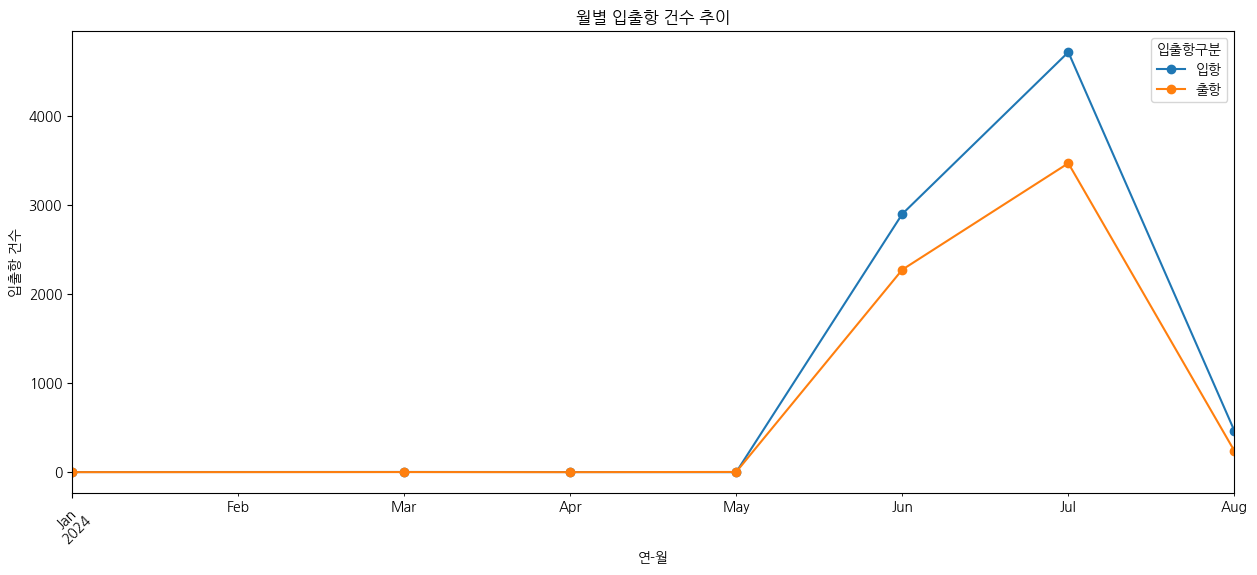

In [542]:
# plt.figure(figsize=(15, 6)) # figsize=(15, 6): 가로 15인치, 세로 6인치 → 넓고 시계열 보기 좋게 설정
monthly_trend.plot(kind="line", marker="o", figsize=(15, 6))
plt.title("월별 입출항 건수 추이")
plt.xlabel("연-월")
plt.ylabel("입출항 건수")
plt.xticks(rotation=45) # X축 눈금(입항연월)이 겹치지 않도록 45도 회전

In [543]:
monthly_trend

입출항구분,입항,출항
입항연월,,
2024-01,1,0
2024-03,2,1
2024-04,1,0
2024-05,0,2
2024-06,2898,2273
2024-07,4715,3468
2024-08,464,238


# 입출항 횟수 틀림

5월까지는 입항과 출항 모두 거의 0건에 가깝다가 6월부터 입출항 건수가 급격히 증가합니다. 이를 통해 본격적인 운항 시작 시점 또는 관측 시작 시점으로 추정된다고 판단할 수 있습니다.

월별로 분석해 보겠습니다.
- 6월: 입항은 약 2,300건, 출항은 약 1,900건입니다. 입항이 출항보다 더 많아 선박 체류 증가 가능성을 나타냅니다.

- 7월: 입항은 약 3,900건, 출항은 약 3,000건입니다. 전월 대비 입출항 모두 증가했고 특히 입항은 큰 폭의 증가했습니다. 여름 성수기나 항만 이용 증가 시기로 판단됩니다.

In [544]:
#######################################################################################################################################
'''
1. 기후 조건 – 기상 안정성

여름(특히 6~8월)은 한국·중국·일본 항로에서 기상 조건이 상대적으로 안정됨.

겨울: 높은 파도, 강한 바람, 해빙 위험 → 운항 취소 증가
여름: 파고 낮음, 시야 확보, 해무 적음 → 운항 증가

특히 연안 해운, 카페리, 어업 선박은 기상에 매우 민감함

✅ 요약: 운항 안전성과 확실성이 높아지기 때문에 선박이 더 많이 움직임

4. 무역 및 산업 물동량

산업계에서 하반기 생산을 위한 원자재 조달 시점이 여름과 겹침
제조업 공장 가동률 증가에 맞춰 원자재 입항

조선, 철강, 석유화학, 전자 부품 등의 부품 조달 시기
특히 3분기부터 수출 대비 준비를 여름에 하므로 하계 입항 증가

✅ 요약: 하반기 산업 생산 대비 → 원자재 수입 및 중간재 물동량 증가
'''
#######################################################################################################################################

'\n1. 기후 조건 – 기상 안정성\n\n여름(특히 6~8월)은 한국·중국·일본 항로에서 기상 조건이 상대적으로 안정됨.\n\n겨울: 높은 파도, 강한 바람, 해빙 위험 → 운항 취소 증가\n여름: 파고 낮음, 시야 확보, 해무 적음 → 운항 증가\n\n특히 연안 해운, 카페리, 어업 선박은 기상에 매우 민감함\n\n✅ 요약: 운항 안전성과 확실성이 높아지기 때문에 선박이 더 많이 움직임\n\n4. 무역 및 산업 물동량\n\n산업계에서 하반기 생산을 위한 원자재 조달 시점이 여름과 겹침\n제조업 공장 가동률 증가에 맞춰 원자재 입항\n\n조선, 철강, 석유화학, 전자 부품 등의 부품 조달 시기\n특히 3분기부터 수출 대비 준비를 여름에 하므로 하계 입항 증가\n\n✅ 요약: 하반기 산업 생산 대비 → 원자재 수입 및 중간재 물동량 증가\n'

### 2.2. 화물 톤수 및 화물 종류별 분석

각 화물 톤수 변수의 전체 분포 형태를 파악하고, 이상치 유무, 중심 경향 등을 시각적으로 확인해 보겠습니다.

seaborn 라이브러리의 `histoplot()`을 사용해 각 톤수 변수의 히스토그램과 커널 밀도 추정(KDE) 곡선을 함께 시각화합니다.


'\nfig, ax = plt.subplots(1,2, constrained_layout=True) # constrained_layout=True  그래프 사이 적당히 띄움,\n이 인자를 plt.tight_layout()  대신 줘도 된다\nconstrained_layout=True  이걸 주는게 더 안전\n'

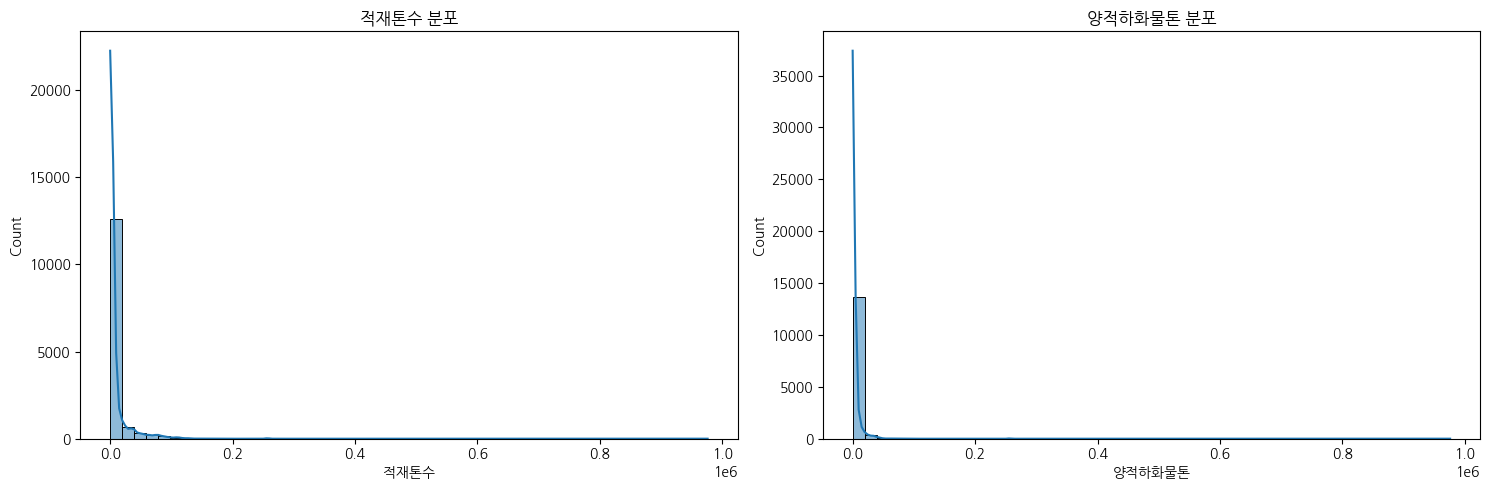

In [545]:

fig1, axes1 = plt.subplots(1, 2, figsize=(15, 5))
#######################################################################################################################################
# 1행 2열짜리 subplot 구성 (→ 가로로 두 개의 그래프)
# axes1은 리스트 형태로 두 개의 Axes 객체를 담고 있음 → axes1[0], axes1[1]

# 히스토그램 (Histogram)	데이터를 일정한 구간(bins)으로 나눠서 각 구간에 속한 데이터 개수를 세는 도수분포
'''
KDE는 데이터를 부드러운 곡선 형태로 확률밀도함수처럼 추정한 것 — 즉, 히스토그램의 부드러운 대체물
즉, 히스토그램이 보여주는 이산적인 막대를 연속적인 곡선으로 보완하는 역할을 함
kde=True를 주었을 때 히스토그램 위에 그려지는 선 하나,
그게 바로 커널 밀도 추정(Kernel Density Estimation, KDE) 곡선이야.
"이 데이터가 특정 구간에 나타날 확률이 어느 정도인가?"를 추정한 연속적인 곡선 형태의 확률밀도함수 (PDF)

✅ 2. KDE는 y축 = 확률 밀도 (density)
즉, 아래 면적을 다 합치면 1이 되도록 조정됨
데이터가 몰린 구간에서는 밀도 값이 상당히 커질 수 있음
→ 그래서 히스토그램 막대보다 위로 튀어나오는 것처럼 보임
KDE는 전체 면적이 1이 되도록 스케일링되기 때문에, 단위당 높이가 더 커질 수 있음.
'''
# 히스토그램과 KDE, 둘을 왜 같이 보나?
'''
히스토그램은 데이터가 어떤 구간에 몰려 있는지 확인할 수 있지만, 구간(bins)의 개수나 위치 설정에 따라 모양이 달라질 수 있는 단점이 있어.
이 때 KDE를 함께 보면:
분포의 전체 윤곽을 더 부드럽게 파악할 수 있다.

적재톤수 : 선박에 실린 전체 화물의 무게 (톤 단위)
양적하화물톤 : 하역한 전체 화물의 무게 (톤 단위)
'''

sns.histplot(df["적재톤수"], bins=50, kde=True, ax=axes1[0]).set_title("적재톤수 분포")
# bins=50: 구간을 50개로 나눔 → 더 정밀한 분포 확인 가능
# ax=axes1[0]: 첫 번째 서브플롯에 그림을 그리겠다는 뜻
sns.histplot(df["양적하화물톤"], bins=50, kde=True, ax=axes1[1]).set_title("양적하화물톤 분포")

plt.tight_layout()
# 두 subplot 사이의 여백이 겹치지 않도록 자동으로 여백 조정
'''
fig, ax = plt.subplots(1,2, constrained_layout=True) # constrained_layout=True  그래프 사이 적당히 띄움,
이 인자를 plt.tight_layout()  대신 줘도 된다
constrained_layout=True  이걸 주는게 더 안전
'''
#######################################################################################################################################

In [546]:
#######################################################################################################################################
print(df["적재톤수"].min(), df["적재톤수"].max())
print(df["양적하화물톤"].min(), df["양적하화물톤"].max()) # 1e6은 백만
#######################################################################################################################################

0.0 975900.0
0.0 975900.0


현재 시각화된 히스토그램을 보면 대부분의 데이터가 왼쪽에 밀집되어 있고, x축이 긴 꼬리를 가진 비대칭 형태를 보이고 있습니다. 이는 일부 극단적인 값(이상치) 때문에 전체 분포가 왜곡되어 발생하는 현상입니다.

따라서, 사분위수 기반의 기준(IQR)을 활용해 이상치를 제거하고, 보다 대표적인 데이터 분포를 확인해 보겠습니다.

# 박스플롯을 그려보자

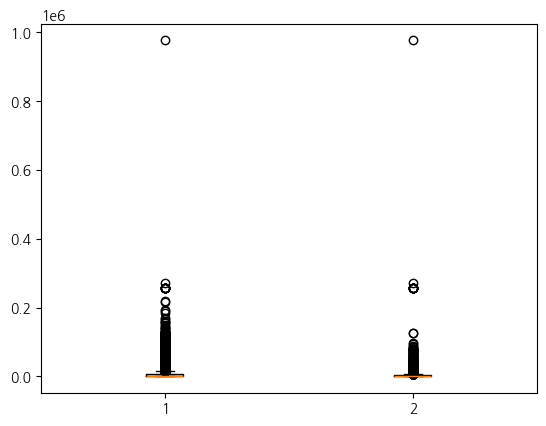

In [547]:
#######################################################################################################################################
plt.boxplot([df["적재톤수"], df["양적하화물톤"]])
plt.show()
#######################################################################################################################################

In [548]:
#######################################################################################################################################
# 이상치 제거전
print(f"이상치 제거 전 데이터 크기: {df.shape}")
#######################################################################################################################################

이상치 제거 전 데이터 크기: (14063, 29)


In [549]:
def remove_outliers_iqr(df, column):
    #######################################################################################################################################
    '''
	Q1 하위 25% 지점
	Q2 중앙값 = 전체의 50% 지점
	Q3 하위 75% = 상위 25% 남긴지점


	[1,2,3,4,5,6,7,8,9]
	Q1 = 3 : Q1은 중앙 50% 의 시작위치
	Q2 = 5
	Q3 = 7 : Q3은 중앙 50% 의 끝 위치

	IQR = Q3 - Q1 = Interquartile Range 사분위범위

	IQR은 데이터의 중앙 50% 가 퍼져있는 구간의 폭을 의미
	즉 Q1과 Q3 사이의 거리
	이 거리, 폭 안에 중앙 50% 데이터가 몰려 있다.

		폭이 작다는건 데이터들이 평균 근처에 몰려 있다는 것 -> 데이터 안정적
		폭이 크다는 건 데이터들이 평균에서 멀리 퍼져 있다는 것 -> 데이터 불안정

	데이터의 이상치를 판별할때, 얼마나 벗어났는지를 판단하는 기준값

		Q1 - 1.5 * IQR 보다 작거나
		Q3 + 1.5 * IQR 보다 크면
		이상치로 간주

	왜 1.5를 곱하냐? → 통계적으로 경험적으로 검증된 기준값이기 때문이고,
	대부분의 데이터 분포에서 정상값을 포괄하는 적절한 범위로 알려져 있어.
    '''
    #######################################################################################################################################
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    # column의 값이 lower_bound 이상이고, upper_bound 이하인 행들만 선택


# 이상치 제거 대상 컬럼
target_columns = ["적재톤수", "양적하화물톤"]

# 각 컬럼별 이상치 제거 적용
for col in target_columns:
    df = remove_outliers_iqr(df, col) # 선택행 행들만 df에 다시 할당

# 결과 확인
print(f"이상치 제거 후 데이터 크기: {df.shape}")

이상치 제거 후 데이터 크기: (11662, 29)


이제 다시 데이터를 확인해 보겠습니다.

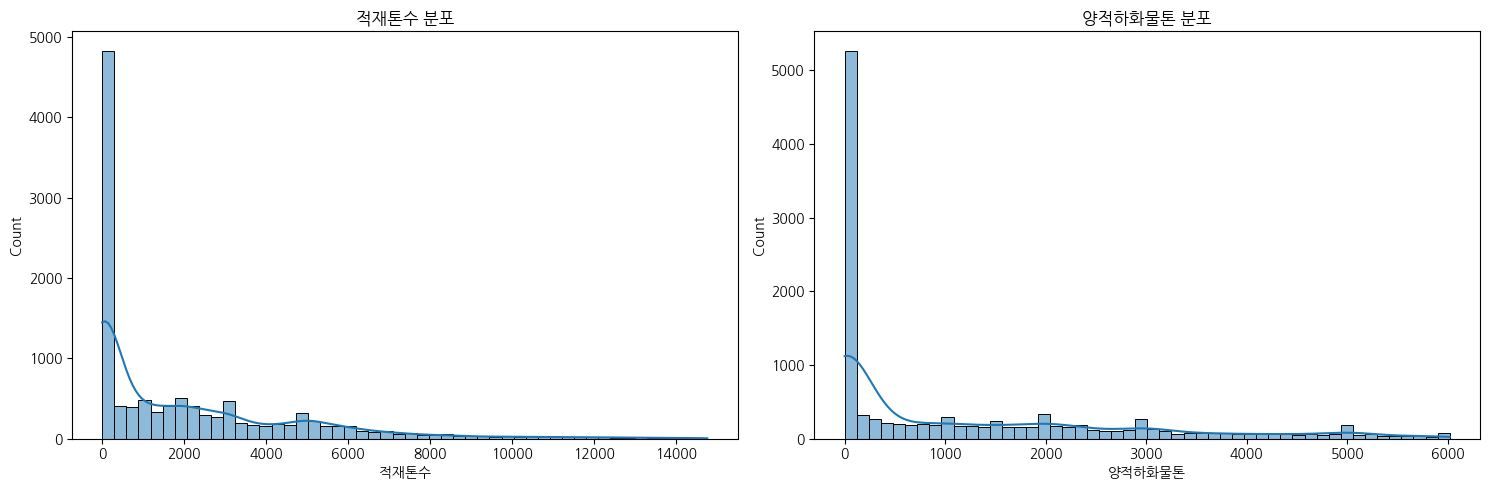

In [550]:
fig1, axes1 = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df["적재톤수"], bins=50, kde=True, ax=axes1[0]).set_title("적재톤수 분포")
sns.histplot(df["양적하화물톤"], bins=50, kde=True, ax=axes1[1]).set_title("양적하화물톤 분포")
plt.tight_layout()

이전 그래프에서는 이상치로 인해 x축이 넓게 분포하면서, 대부분의 데이터가 0 근처에 몰려 있는 것처럼 보였습니다. 이로 인해 실제 주요 분포 구간의 패턴을 시각적으로 파악하기 어려웠습니다.

반면, 이상치를 제거한 이후의 그래프에서는 데이터가 집중된 구간이 더 명확히 드러나며, 전체적인 분포의 형태를 보다 직관적으로 확인할 수 있습니다. 특히 `적재톤수`와 `양적하화물톤` 모두에서, 소수의 극단값에 의해 왜곡되었던 밀도 분포가 완화되어 실제 데이터의 중심 경향과 분포의 꼬리 부분이 더욱 뚜렷하게 나타납니다.

다음으로 화물 종류별 평균 적재톤수 상위 20개 항목을 막대그래프로 시각화해 보겠습니다.

`적재화물명`을 기준으로 그룹화하고 각 그룹에 대해 `적재톤수`의 평균값을 계산합니다. 계산한 평균값을 내림차순으로 정렬하고 그중 상위 20개 항목만 추출하여 `top_cargo`에 저장합니다. 즉, `top_cargo`는 평균적으로 가장 무거운 화물을 상위 20개까지 뽑아낸 것입니다.

In [551]:
# 화물 종류별 평균 적재톤수 (상위 20개)
top_cargo = df.groupby("적재화물명")["적재톤수"].mean().sort_values(ascending=False).head(20)

top_cargo

적재화물명
아연            10818.000000
동COPPER        6717.796000
알루미늄           6466.272727
펄프             5602.200000
각종비금속제품        5000.000000
연              4828.600000
목재.목탄          4762.243913
기타의비금속         4735.667802
돌,시멘트,석면제품     4553.347826
유리             4500.000000
토석,소금          4328.340426
동식물성유지         4277.666667
당류.설탕과자        4254.428571
지.판지           4219.814815
비료             4070.789474
전기기기           3611.236842
차량             3586.671498
곡물             3448.868421
연료,에너지         3428.850971
광,슬랙,회         3428.639231
Name: 적재톤수, dtype: float64

이 `top_cargo`를 사용하여 막대그래프를 그려보겠습니다.

Text(0, 0.5, '화물 종류')

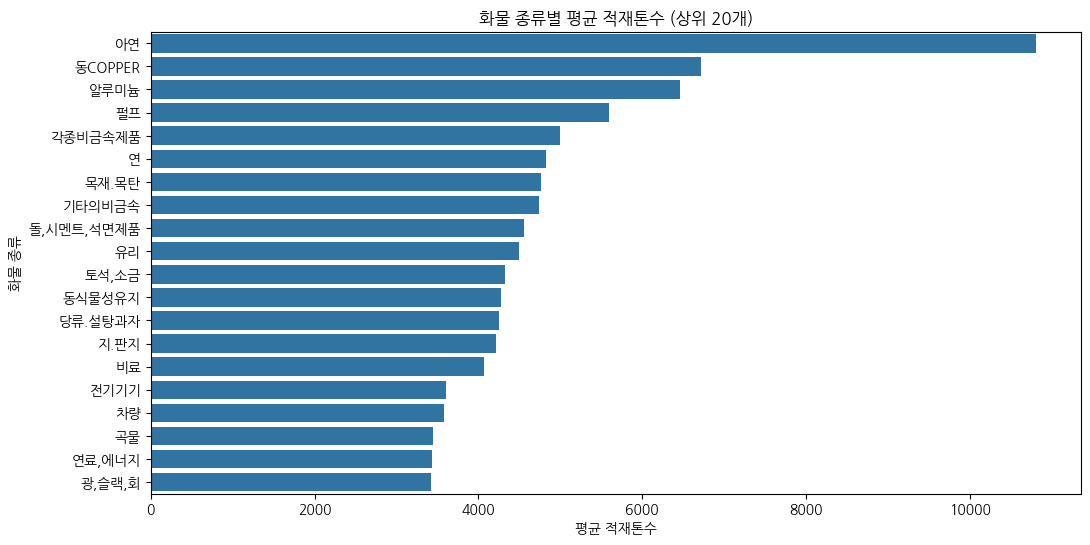

In [552]:
plt.figure(figsize=(12, 6))
sns.barplot(x=top_cargo.values, y=top_cargo.index)
plt.title("화물 종류별 평균 적재톤수 (상위 20개)")
plt.xlabel("평균 적재톤수")
plt.ylabel("화물 종류")

아연은 평균 적재톤수가 1만 톤 이상으로 가장 높습니다. 이는 야연이 대형 선박으로 주로 운송되고 있음을 의미합니다. 다음으로 동, 알루미늄, 펄프는 각각 6,000~7,000톤 수준으로 중량 화물로 분류됩니다. 비철금속 및 원자재 성격이 강해 대규모 단위 운송이 이뤄지는 것으로 보입니다.

각종비금속제품, 연, 기타비금속 등은 대부분 원자재 또는 중간재로서 대량 운송이 필요한 품목입니다. 돌·시멘트·석면제품, 유리, 도석·소금 등 건설·건축 자재도 눈에 띄며, 이들 역시 단위당 무게가 크기 때문에 평균 적재량이 높게 나옵니다.

비료, 차량, 곡물, 연료·에너지, 광,슬랙,회 등은 중간 이하에 분포되어 있으며, 상대적으로 적재량 단위가 작거나 분산 수송되는 특성이 있습니다.

## 3. 데이터 전처리

데이터 전처리는 본격적인 분석이나 모델링에 앞서 데이터의 품질을 개선하고, 의미 있는 정보를 추출 가능한 형태로 변환하는 필수 작업입니다. 원본 데이터는 종종 불완전하거나, 중복되거나, 분석 목적과 맞지 않는 구조를 가지는 경우가 많기 때문에, 이를 정제하지 않고 분석하면 오류, 편향, 비효율적인 결과가 발생할 수 있습니다.

이번 선박 입출항 데이터에서도 다양한 변수들이 존재하며, 이를 효과적으로 활용하기 위해 전처리 작업을 순차적으로 수행합니다.

### 3.1. 중복값, 이상치, 결측치 제거

**중복값**, **이상치**, **결측치** 제거는 데이터 전처리에서 매우 중요한 단계입니다. 이 세 가지 처리 과정은 데이터의 신뢰성과 예측 성능 향상을 위해 반드시 수행되어야 합니다.

#### 중복값 제거

동일한 선박이 동일한 시각에 동일한 정보로 두 번 이상 기록되는 경우 등 중복된 행이 존재할 수 있습니다. 중복값은 데이터의 왜곡을 일으키고, 모델 학습 시 편향된 결과를 초래할 수 있습니다.

전체 컬럼을 기준으로 중복값의 개수를 확인하고 제거하겠습니다.

In [553]:
len(df)

11662

In [554]:
print(df.duplicated().sum()) # *DataFrame에서 완전히 똑같은(중복된) 행(row)**이 몇 개인지를 세서 출력하는 코드
#######################################################################################################################################
'''
1. df.duplicated()
df의 각 행이 앞에서 이미 등장한 적이 있는지 여부를 불린 시리즈로 반환

즉, True = 중복됨, False = 처음 나옴
'''
#######################################################################################################################################

379


'\n1. df.duplicated()\ndf의 각 행이 앞에서 이미 등장한 적이 있는지 여부를 불린 시리즈로 반환\n\n즉, True = 중복됨, False = 처음 나옴\n'

In [555]:
df = df.drop_duplicates()

print(f"중복값 제거 후 데이터 크기: {df.shape}")

중복값 제거 후 데이터 크기: (11283, 29)


11,662개였던 데이터가 11,283개로 줄어든 것을 확인할 수 있습니다.


#### 이상치 제거

이상치는 데이터 분포에서 극단적으로 벗어난 값으로, 대부분 입력 오류, 측정 오류 또는 비정상적 상황에서 발생합니다. 이상치는 평균, 분산, 회귀 계수 등에 큰 영향을 주어 모델의 왜곡을 초래하고, 예측 성능을 저하시킵니다.

이전에 `적재톤수`, `환적톤수`는 이상치 제거 완료했기 때문에 `총톤수`에 대해서 이상치를 제거하겠습니다. (`양적하화물톤`과 `위험물톤수`, `징수결정톤수`는 크게 데이터분포값이 차이나지 않습니다.)

# 이상치 제거시 적재톤수, 양적화화물톤을 했는데 환적톤수를 했다고 나옴.

# 환적톤수, 위험물톤수는 데이터 분포값이 차이 남

# 박스플롯을 그려보자

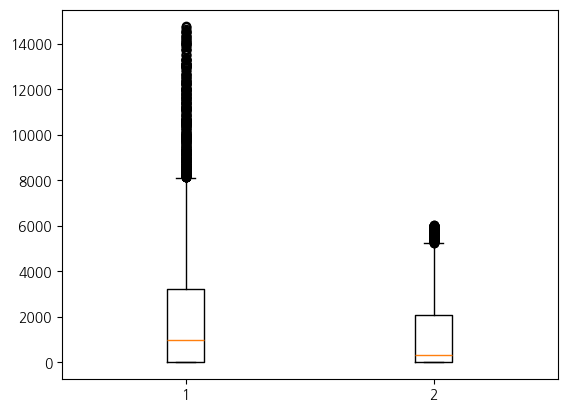

In [556]:
#######################################################################################################################################
plt.boxplot([df["적재톤수"], df["양적하화물톤"]])
plt.show()
#######################################################################################################################################

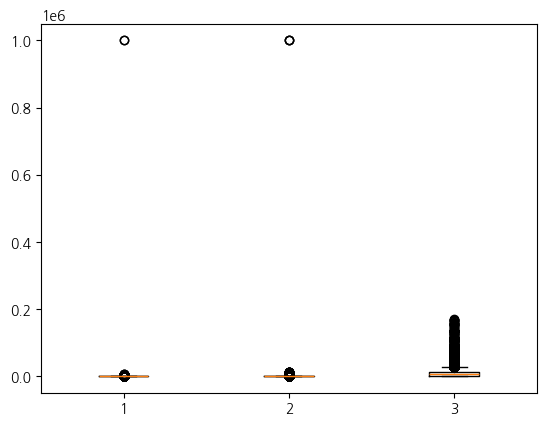

In [557]:
#######################################################################################################################################
'''
환적톤수 : 다른 선박으로 환적 예정인 화물의 무게
위험물톤수 :위험물로 분류된 화물의 무게 (톤 단위)
징수결정톤수 :항만 사용료나 하역료 등 부과 기준이 되는 톤수
'''

plt.boxplot([df["환적톤수"], df["위험물톤수"], df["징수결정톤수"]])
plt.show()
#######################################################################################################################################

# 이상치만 뽑아서 봐보자

In [558]:
#######################################################################################################################################
def count_outliers_iqr(df, column):
    # remove_outliers_iqr과 동일한데
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]  이것만 다름.
    # 이건 정상값(이상치 제외)**을 추출하는 거고,

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)] # 이상치만 추출하는 코드야.
    return len(outliers)

target_columns  = ["환적톤수", "위험물톤수"]
for col in target_columns:
    print(count_outliers_iqr(df, col))

# 이상치 뽑아본 결과
'''
이건 비정상적으로 많은 이상치야.
보통 IQR로 잘라낸 이상치는 정상 데이터의 5~10% 수준이 이상적인데, 40%는 이상치가 아니라 분포 특성이 의심돼.
4500개가 이상치로 판단됐다는 건, 전체의 약 41%가 IQR 범위를 벗어났다는 뜻이고,
이는 단순한 이상치(outlier)가 아니라 **데이터 분포 자체가 비대칭적이거나 다중봉(multi-modal)**일 가능성이 높아.
'''
#######################################################################################################################################

1901
2690


'\n이건 비정상적으로 많은 이상치야.\n보통 IQR로 잘라낸 이상치는 정상 데이터의 5~10% 수준이 이상적인데, 40%는 이상치가 아니라 분포 특성이 의심돼.\n4500개가 이상치로 판단됐다는 건, 전체의 약 41%가 IQR 범위를 벗어났다는 뜻이고,\n이는 단순한 이상치(outlier)가 아니라 **데이터 분포 자체가 비대칭적이거나 다중봉(multi-modal)**일 가능성이 높아.\n'

# 히스토그램을 그려보자

'\n한쪽으로 밀집된 값 + 긴 꼬리? → 로그 변환 고려  >>>>>>>>>>>>>>>>>> 맨 아래에서 수치형 변수 변환할때 자세히\n변수 x에 대해 log(x) 또는 log1p(x) 형태로 값을 함수적으로 줄이는 비선형 변환을 말해.\n→ 차이가 배수 단위로 커지는 값들을 지수 단위로 축소함\n→ 이렇게 되면 큰 값의 영향이 줄어들고, 꼬리가 줄어든다\n\n❓ 변환만 하면 바로 써도 될까? ✔️ "쓸 수는 있다"\n로그 변환된 값을 그대로 모델 학습에 넣거나, 이상치 제거에 사용해도 됨.\n❗ 단, 아래를 주의해야 한다다\n1. 변환 전과 단위가 완전히 다르다\n    예: 톤수 → 로그 톤수\n    해석할 때도 "배수"가 아닌 "로그스케일"로 읽어야 함\n\n2. 학습시 타겟값을 로그변환 했다면\n학습 완료후 추론시 모델이 예측하는 값도 로그 단위가 되므로 예측값을 역변환해야함\nnp.expm1(y_pred)\n\n3. 모델을 트리기반을 쓰면 제거할 필요가 떨어진다.\n'

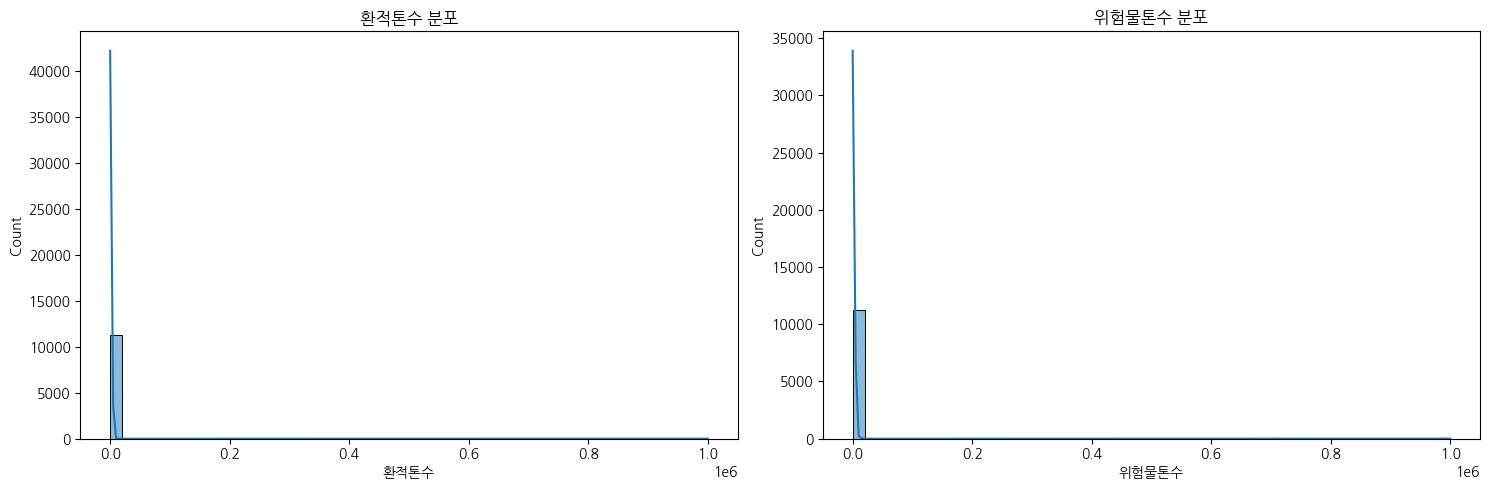

In [559]:
#######################################################################################################################################
fig1, axes1 = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df["환적톤수"], bins=50, kde=True, ax=axes1[0]).set_title("환적톤수 분포")
sns.histplot(df["위험물톤수"], bins=50, kde=True, ax=axes1[1]).set_title("위험물톤수 분포")
plt.tight_layout()
'''
한쪽으로 밀집된 값 + 긴 꼬리? → 로그 변환 고려  >>>>>>>>>>>>>>>>>> 맨 아래에서 수치형 변수 변환할때 자세히
변수 x에 대해 log(x) 또는 log1p(x) 형태로 값을 함수적으로 줄이는 비선형 변환을 말해.
→ 차이가 배수 단위로 커지는 값들을 지수 단위로 축소함
→ 이렇게 되면 큰 값의 영향이 줄어들고, 꼬리가 줄어든다

❓ 변환만 하면 바로 써도 될까? ✔️ "쓸 수는 있다"
로그 변환된 값을 그대로 모델 학습에 넣거나, 이상치 제거에 사용해도 됨.
❗ 단, 아래를 주의해야 한다다
1. 변환 전과 단위가 완전히 다르다
    예: 톤수 → 로그 톤수
    해석할 때도 "배수"가 아닌 "로그스케일"로 읽어야 함

2. 학습시 타겟값을 로그변환 했다면
학습 완료후 추론시 모델이 예측하는 값도 로그 단위가 되므로 예측값을 역변환해야함
np.expm1(y_pred)

3. 모델을 트리기반을 쓰면 제거할 필요가 떨어진다.
'''
#######################################################################################################################################

# 어떻게 할지 두고보자 (아래서 수치형 변수 변환시 로그변환시킴)

In [560]:
# 이상치 제거 대상 컬럼
target_columns = ["총톤수"]

# 각 컬럼별 이상치 제거 적용
for col in target_columns:
    df = remove_outliers_iqr(df, col)

# 결과 확인
print(f"이상치 제거 후 데이터 크기: {df.shape}")

이상치 제거 후 데이터 크기: (9771, 29)


11,283개였던 데이터가 9,771개로 줄어든 것을 확인할 수 있습니다.

#### 결측치 제거

결측치를 제거하기 전, 불필요한 컬럼을 제거하겠습니다. 삭제할 컬럼명은 다음과 같습니다.

- 불필요한 정보 : `신고일시`, `등록일시`, `수정일시`, `항구청코드`, `입항횟수`, `입항목적명`, `선박국적명`, `선박종류명`
- 출항/목적지 관련 세부 위치 정보: `전출항지국가명`, `전출항지항구명`, `차항지국가명`,`목적지국가명`, `목적지항구명`, `계선시설명`
- 중간 파생 변수: `입항연월`

# 위와 같이 판단하는 근거가 뭘까
# 명목형 범주 칼럼들을 직접 뽑아보자

In [561]:
#######################################################################################################################################
'''
체류시간 = 입항일시 ~ 출항일시 사이의 시간차
→ 체류시간에 영향을 줄 수 있는 변수를 남기고,
→ 직접적 기여가 없거나 중복되거나 데이터 품질이 낮은 변수는 제거하는 논리를 찾아보자자
'''

def summarize_nominal_columns(df, columns):
    """
    명목형 범주 컬럼들의 고유값과 개수를 요약하는 함수.

    1. 해당 열에서 중복값을 모두 포함해
    2. 고유값(unique value)을 찾아내고
    3. 각 값이 총 몇 번 나왔는지(count)를 계산한 후
    4. 고유값: 개수 형태의 딕셔너리로 정리해줌

    """
    summary = {}

    for col in columns:
        # .value_counts : Series의 고유값(unique values)을 기준으로 **그 값이 등장한 횟수(count)**를 세는 함수야.
        # .to_dict = 위에서 얻은 Series(고유값 ↔ count)를 Python의 딕셔너리로 변환
        # dropna=False 옵션을 주면 **결측값(NaN)**도 하나의 범주로 포함시켜 보여줘
        value_counts = df[col].value_counts(dropna=False).to_dict()
        # value_counts()는 자동으로 내림차순 정렬돼 있어서 많~적 순으로 볼 수 있어

        summary[col] = {
            "종류 수": len(value_counts),
            "고유값": value_counts
        }

    return summary
#######################################################################################################################################

# 아래 칼럼 제거 코드블럭에서 제거할 칼럼들을 가져와 보자

In [562]:
#######################################################################################################################################
drop_columns = [
    "신고일시", "등록일시", "수정일시", "입항연월",  # 메타정보라 관련 없을 듯. 신고일시는 입출항신고일시 인데 관련없나?
    "전출항지국가명", "전출항지항구명",  # 체류시간과 직접 인과관계 없음
    "차항지국가명", "차항지항구명",     # 체류시간과 직접 인과관계 없음
    "목적지국가명", "목적지항구명",     # 체류시간과 직접 인과관계 없음

    "항구청코드",  # 이건 관련 있지 않을까?
    "입항횟수",
    "계선시설명",  # 이건 관련 있지 않을까? 특정 부두의 물류처리 속도가 다를 수 있고 체류시 이득을 볼 수 있는 시설들이 있다면?

    "입항목적명", # 이건 왜날릴까?
    "선박국적명",
    "선박종류명"  # 이건 왜날릴까? 선박 종류명은 의미 있을것 같은데?
]

summary = summarize_nominal_columns(df, drop_columns)
summary
#######################################################################################################################################

{'신고일시': {'종류 수': 9111,
  '고유값': {'2024-07-18 18:19:11': 16,
   '2024-06-14 14:36:30': 12,
   '2024-07-06 10:44:43': 10,
   '2024-07-12 16:42:17': 5,
   '2024-07-18 10:41:14': 5,
   '2024-06-16 09:59:13': 4,
   '2024-06-16 15:40:14': 4,
   '2024-07-13 08:17:27': 4,
   '2024-07-13 09:17:39': 4,
   '2024-08-27 16:15:51': 4,
   '2024-07-12 16:42:53': 4,
   '2024-06-16 15:39:16': 4,
   '2024-08-08 08:03:43': 4,
   '2024-07-07 09:21:51': 4,
   '2024-07-31 08:55:59': 3,
   '2024-06-17 22:15:39': 3,
   '2024-07-03 09:28:24': 3,
   '2024-07-22 10:23:00': 3,
   '2024-07-10 09:27:13': 3,
   '2024-07-12 16:50:12': 3,
   '2024-06-17 10:26:37': 3,
   '2024-07-09 09:14:41': 3,
   '2024-06-28 08:53:00': 3,
   '2024-07-02 13:15:00': 3,
   '2024-07-08 09:36:38': 3,
   '2024-06-18 13:11:55': 3,
   '2024-07-06 16:41:22': 3,
   '2024-07-08 11:30:14': 3,
   '2024-08-01 08:29:56': 3,
   '2024-07-01 13:22:00': 3,
   '2024-06-17 09:04:23': 3,
   '2024-07-06 10:56:50': 3,
   '2024-07-06 16:46:44': 3,
   '2024-

In [563]:
#######################################################################################################################################
# ✅ 1. 카테고리 수가 많으면 왜 문제인가?
'''
범주형 변수의 고유값 종류 수가 너무 많을 때 생기는 문제는 다음과 같아:

⚠️ 1.1 원핫 인코딩 시 차원 폭발
고유값이 1000개면 → 원핫 인코딩 결과 1000개의 컬럼 생성됨

데이터 희소해지고 → 계산량 증가 + 과적합 가능성 높아짐

⚠️ 1.2 샘플 수 대비 정보량이 너무 작음 (High Cardinality)
일부 값은 샘플 수가 1~2개밖에 없는데, 모델은 그걸 별도로 처리함 → 노이즈로 작용

모델이 희소한 특성에 의미를 부여하게 되면 과적합(overfitting) 발생

⚠️ 1.3 트리 기반 모델에서 분할 수 증가
XGBoost, RandomForest는 범주형도 내부적으로 정수 인코딩 or 다중 분할로 처리

고카디널리티는 split 후보 수 증가 → 학습 시간 급증 → 일반화 성능 저하
'''
# ✅ 2. "한 자리 수만 있는 카테고리"는 지워야 할까?
'''
✔️ 기본 원칙:
카테고리의 데이터 수가 너무 적으면 → 일반적으로 합치거나 제거하는 게 바람직

전체 샘플 수 > 10000	각 범주에 최소 30개 이상 없으면 위험
특정 카테고리 샘플 수 < 5~10개	거의 무조건 제거 또는 합쳐야 함
전체 카테고리 중 90%가 소수 샘플	축소 또는 상위 N개만 유지 후 나머지는 "기타" 처리
'''
#######################################################################################################################################

'\n✔️ 기본 원칙:\n카테고리의 데이터 수가 너무 적으면 → 일반적으로 합치거나 제거하는 게 바람직\n\n전체 샘플 수 > 10000\t각 범주에 최소 30개 이상 없으면 위험\n특정 카테고리 샘플 수 < 5~10개\t거의 무조건 제거 또는 합쳐야 함\n전체 카테고리 중 90%가 소수 샘플\t축소 또는 상위 N개만 유지 후 나머지는 "기타" 처리\n'

In [564]:
drop_columns = [
    "신고일시", "등록일시", "수정일시", "입항연월",  # 메타정보라 관련 없을 듯. 신고일시는 입출항신고일시 인데 관련없나?
    "전출항지국가명", "전출항지항구명",  # 체류시간과 직접 인과관계 없음
    "차항지국가명", "차항지항구명",     # 체류시간과 직접 인과관계 없음
    "목적지국가명", "목적지항구명",     # 체류시간과 직접 인과관계 없음

    "항구청코드",  # 이건 관련 있지 않을까?
    "입항횟수",
    "계선시설명",  # 이건 관련 있지 않을까? 특정 부두의 물류처리 속도가 다를 수 있고 체류시 이득을 볼 수 있는 시설들이 있다면?

    "입항목적명", # 이건 왜날릴까?
    "선박국적명",
    "선박종류명"  # 이건 왜날릴까? 선박 종류명은 의미 있을것 같은데?
]

df = df.drop(columns=drop_columns)

df

,입출항구분,호출부호,입항년도,적재화물명,적재톤수,환적톤수,양적하화물톤,위험물톤수,징수결정톤수,총톤수,내외항구분,선박명,입출항일시
0,입항,UEPG,2024,해당없음,0.000,0.0,0.000,0.0,4860,4860.0,외항,DIMA,2024-01-18 00:15:00
1,입항,UEPG,2024,기타,1270.000,0.0,0.000,0.0,4860,4860.0,외항,DIMA,2024-03-07 11:25:00
2,입항,HP5145,2024,해당없음,0.000,0.0,0.000,0.0,499,499.0,외항,GOLDEN CROWN,2024-03-22 20:35:00
3,출항,HP5145,2024,해당없음,0.000,0.0,0.000,0.0,499,499.0,외항,GOLDEN CROWN,2024-03-23 05:20:00
4,입항,UEPG,2024,기타,5001.000,0.0,0.000,0.0,4860,4860.0,외항,DIMA,2024-04-10 08:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14046,입항,VRAD3,2024,잡품,189.000,0.0,189.000,39.0,7167,7167.0,외항,JI RUN,2024-08-08 16:39:00
14051,입항,V3OJ6,2024,차량,638.315,0.0,638.315,0.0,6635,6635.0,외항,JOYO 6,2024-08-09 04:15:00
14052,입항,3FLX7,2024,잡품,6715.000,4526.0,5634.000,77.0,9870,9870.0,외항,SUNNY CANNA,2024-08-09 04:40:00
14053,입항,V3ZQ,2024,해당없음,0.000,0.0,0.000,0.0,1486,1486.0,외항,HIROI,2024-08-09 18:14:00


체류시간 예측에 필요한 컬럼 13개를 제외하고 나머지 컬럼은 모두 제거했습니다.

다음으로는 결측치를 제거하겠습니다. 결측치가 존재하는 컬럼을 확인합니다.

In [565]:
df.isnull().sum()
#######################################################################################################################################
'''
호출부호      선박 고유 식별코드니까 필요하고

체류시간에 직접 영향미치는
    입출항구분
    입출항일시

간접 영향 미칠 수 있는
    내외항구분      입출항 처리 절차 대기시간에 영향 미칠 수 있고
    선박명
    적재화물명     `적재화물명`과 톤수 정보는 처리 시간에 직접 영향을 주므로 중요한 정보
    적재톤수
    환적톤수
    양적하화물톤
    위험물톤수
    징수결정톤수
    총톤수
입항년도      이건 왜 있을까?
'''
#######################################################################################################################################

'\n호출부호      선박 고유 식별코드니까 필요하고\n\n체류시간에 직접 영향미치는\n    입출항구분\n    입출항일시\n\n간접 영향 미칠 수 있는\n    내외항구분      입출항 처리 절차 대기시간에 영향 미칠 수 있고\n    선박명\n    적재화물명     `적재화물명`과 톤수 정보는 처리 시간에 직접 영향을 주므로 중요한 정보\n    적재톤수\n    환적톤수\n    양적하화물톤\n    위험물톤수\n    징수결정톤수\n    총톤수\n입항년도      이건 왜 있을까?\n'

현재 데이터프레임 `df`에는 결측치가 존재하지 않습니다.

### 3.2. 체류시간 컬럼 생성

선박이 항구에 머문 시간을 파악하여 물류 흐름이나 항만 운영 효율성을 분석하기 위해 `호출부호`, `선박명`, `입출항구분`, `입출항일시` 컬럼을 사용하여 체류시간 컬럼을 생성하겠습니다.

입출항이 여러 번 있는 선박은 구분이 필요하므로 `호출부호`와 `선박명` 컬럼을 조합한 "호출부호_선박명" 형태의 `선박ID` 컬럼을 생성합니다.

# 왜 호출부호와 선박명으로 선박ID 칼럼을 만들어 쓰는 걸까?

In [566]:
a_to_b = df.groupby("호출부호")["선박명"].nunique()
a_to_b

호출부호
0703011    1
0810006    1
18573      1
186220     1
1911007    1
          ..
YDHW3      1
YDIC3      1
YJXR5      1
YJXR6      1
ZGBH8      1
Name: 선박명, Length: 1731, dtype: int64

In [567]:
a_many = a_to_b[a_to_b > 1]
a_many

호출부호
DSRO8    2
Name: 선박명, dtype: int64

In [568]:
#######################################################################################################################################
'''
호출부호와 선박명은 1:1 관계가 아닌건가? 1:1관계라면 왜 둘이 연결하지? 둘 중 하나의 값이 없을수도 있어서?

✅ 목표: 일대일(1:1) 관계인지, 다대일(1:N), 일대다(N:1) 또는 다대다(N:M) 관계인지 확인
'''
def check_column_pair_uniqueness(df, col_a, col_b):
    """
    두 컬럼 간 짝지음 관계를 분석한다.
    - 동일 A가 여러 B와 짝지어졌는지
    - 동일 B가 여러 A와 짝지어졌는지
    결측치는 무시한다.
    """
    # 1. 결측치 제거
    subset = df[[col_a, col_b]].dropna()

    # 2. 동일 A에 대응되는 B의 고유 개수
    a_to_b = subset.groupby(col_a)[col_b].nunique()
    '''
    호출부호
    0703011    1
    0810006    1
    18573      1
    186220     1
    1911007    1
            ..
    YDHW3      1
    YDIC3      1
    YJXR5      1
    YJXR6      1
    ZGBH8      1
    Name: 선박명, Length: 1731, dtype: int64
    '''
    a_many = a_to_b[a_to_b > 1]

    # 3. 동일 B에 대응되는 A의 고유 개수
    b_to_a = subset.groupby(col_b)[col_a].nunique()
    b_many = b_to_a[b_to_a > 1]

    # 결과 출력
    print(f"총 샘플 수: {len(subset)}")
    print(f"\n1️⃣ 동일 {col_a}가 여러 {col_b}와 짝지어진 경우: {len(a_many)}건")
    print(f"예시:\n{a_many.head()}\n")
    print(f"2️⃣ 동일 {col_b}가 여러 {col_a}와 짝지어진 경우: {len(b_many)}건")
    print(f"예시:\n{b_many.head()}\n")

    return a_many, b_many

check_column_pair_uniqueness(df, "호출부호", "선박명")

총 샘플 수: 9771

1️⃣ 동일 호출부호가 여러 선박명와 짝지어진 경우: 1건
예시:
호출부호
DSRO8    2
Name: 선박명, dtype: int64

2️⃣ 동일 선박명가 여러 호출부호와 짝지어진 경우: 7건
예시:
선박명
DEBBIE         2
GLORY STAR     2
GOLDEN BEAR    2
OCEAN GLORY    2
XUAN JING      2
Name: 호출부호, dtype: int64



(호출부호
 DSRO8    2
 Name: 선박명, dtype: int64,
 선박명
 DEBBIE         2
 GLORY STAR     2
 GOLDEN BEAR    2
 OCEAN GLORY    2
 XUAN JING      2
 YONG SHUN      2
 YU SHUN        2
 Name: 호출부호, dtype: int64)

In [569]:
#######################################################################################################################################
'''
1️⃣ 동일 호출부호 → 여러 선박명: 1건
예: DSRO8 호출부호가 2개의 서로 다른 선박명과 짝지음

📌 호출부호 재사용 가능성, 또는 데이터 입력 오류

2️⃣ 동일 선박명 → 여러 호출부호: 7건
예: "DEBBIE" 선박명이 2개의 서로 다른 호출부호와 짝지음

📌 동명이선박, 호출부호 변경, 입력 중복 가능성

❗️해석의 핵심하
“대부분은 1:1이지만, 일부 예외가 있음”
'''
# → 따라서 실무에서는 그 “일부”가 전체 체류시간 계산에 혼란을 줄 수 있기 때문에 조합 ID를 만들어 고유한 식별번호 피쳐를 사용하는 것이 더 안전하다.

#######################################################################################################################################

'\n1️⃣ 동일 호출부호 → 여러 선박명: 1건\n예: DSRO8 호출부호가 2개의 서로 다른 선박명과 짝지음\n\n📌 호출부호 재사용 가능성, 또는 데이터 입력 오류\n\n2️⃣ 동일 선박명 → 여러 호출부호: 7건\n예: "DEBBIE" 선박명이 2개의 서로 다른 호출부호와 짝지음\n\n📌 동명이선박, 호출부호 변경, 입력 중복 가능성\n\n❗️해석의 핵심하\n“대부분은 1:1이지만, 일부 예외가 있음”\n'

In [570]:
# 선박 식별을 위한 기준 컬럼: 호출부호 + 선박명 조합 (호출부호만으로도 가능) #################################################### 이 주석은 틀림림
df["선박ID"] = df["호출부호"].fillna("UNKNOWN") + "_" + df["선박명"].fillna("UNKNOWN")

df["선박ID"]

0                  UEPG_DIMA
1                  UEPG_DIMA
2        HP5145_GOLDEN CROWN
3        HP5145_GOLDEN CROWN
4                  UEPG_DIMA
                ...         
14046           VRAD3_JI RUN
14051           V3OJ6_JOYO 6
14052      3FLX7_SUNNY CANNA
14053             V3ZQ_HIROI
14059             D7XP_WECAN
Name: 선박ID, Length: 9771, dtype: object

입항과 출항을 구분하여 두 개의 DataFrame으로 분리합니다.

각 DataFrame에는 선박ID와 해당 시각만 포함되며, 컬럼명을 각각 `입항일시`, `출항일시`로 변경합니다.

In [571]:
# 입항 / 출항 각각 분리
arr_df = df[df["입출항구분"] == "입항"][["선박ID", "입출항일시"]].rename(columns={"입출항일시": "입항일시"})
dep_df = df[df["입출항구분"] == "출항"][["선박ID", "입출항일시"]].rename(columns={"입출항일시": "출항일시"})

In [572]:
#######################################################################################################################################
df[df["입출항구분"] == "입항"][["선박ID", "입출항일시"]]
#######################################################################################################################################

,선박ID,입출항일시
0,UEPG_DIMA,2024-01-18 00:15:00
1,UEPG_DIMA,2024-03-07 11:25:00
2,HP5145_GOLDEN CROWN,2024-03-22 20:35:00
4,UEPG_DIMA,2024-04-10 08:00:00
19,JVXP7_TAE YOUNG NO.2,2024-06-08 09:00:00
...,...,...
14046,VRAD3_JI RUN,2024-08-08 16:39:00
14051,V3OJ6_JOYO 6,2024-08-09 04:15:00
14052,3FLX7_SUNNY CANNA,2024-08-09 04:40:00
14053,V3ZQ_HIROI,2024-08-09 18:14:00


In [573]:
#######################################################################################################################################
df[df["입출항구분"] == "입항"][["선박ID", "입출항일시"]].rename(columns={"입출항일시": "입항일시"})
#######################################################################################################################################

,선박ID,입항일시
0,UEPG_DIMA,2024-01-18 00:15:00
1,UEPG_DIMA,2024-03-07 11:25:00
2,HP5145_GOLDEN CROWN,2024-03-22 20:35:00
4,UEPG_DIMA,2024-04-10 08:00:00
19,JVXP7_TAE YOUNG NO.2,2024-06-08 09:00:00
...,...,...
14046,VRAD3_JI RUN,2024-08-08 16:39:00
14051,V3OJ6_JOYO 6,2024-08-09 04:15:00
14052,3FLX7_SUNNY CANNA,2024-08-09 04:40:00
14053,V3ZQ_HIROI,2024-08-09 18:14:00


입항 시각과 가장 가까운 출항 시각을 1:1로 매칭하기 위해 `matched_records` 리스트를 생성하겠습니다.

`선박ID`는 각 선박을 고유하게 식별할 수 있는 값입니다. `groupby`를 통해 각 선박에 대해 입항 데이터들과 출항 데이터들을 각각 따로 묶을 수 있습니다. 이후에 같은 `선박ID`를 가진 입항-출항 데이터를 매칭할 수 있게 됩니다.

In [574]:
# 결과 저장용 리스트
matched_records = []

#######################################################################################################################################
# 선박ID 기준으로 입항-출항 그룹핑
grouped_arr = arr_df.groupby("선박ID") # 입항 데이터만 모은 후, 선박ID를 기준으로 그룹을 만든 것
# grouped_arr는 GroupBy 객체이고, 그 안에는 선박ID별로 나눠진 입항 시각 행의 인덱스들이 묶여서 들어 있어.
#######################################################################################################################################
grouped_dep = dep_df.groupby("선박ID")

In [575]:
#######################################################################################################################################
grouped_arr
'''
GroupBy object with groups:
- 호출부호_선박명  → [입항일시1 인덱스, 입항일시2 인덱스, ...]
- ...스
즉, 하나의 선박ID가 여러 번 입항한 경우,
→ 그 선박ID 그룹 안에 입항일시 인덱스들이 리스트처럼 들어 있음
'''
#######################################################################################################################################

'\nGroupBy object with groups:\n- 호출부호_선박명  → [입항일시1 인덱스, 입항일시2 인덱스, ...]\n- ...스\n즉, 하나의 선박ID가 여러 번 입항한 경우,\n→ 그 선박ID 그룹 안에 입항일시 인덱스들이 리스트처럼 들어 있음\n'

In [576]:
#######################################################################################################################################
grouped_arr.groups # 입항일시 인덱스들이 오름차순 정렬
#######################################################################################################################################

{'0703011_NO 111 KWANG MYEONG': [1592, 3472, 5267, 6954, 9592, 10709, 12485, 13723], '0810006_BOKEONG MARINE': [602, 4039, 6057, 9601, 12743], '18573_SILVIE 1': [4152], '1911007_105KWANGMYEONG': [2164, 6110, 8873, 10714, 11724], '2211002_HANILYUROHO': [590, 1875, 2984, 4010, 5553, 7163, 8819, 9581, 12456, 13186], '240030_SPRING ALPHA': [12965], '30977_OCEAN ALEXANDER': [4154], '3E2004_BO YANG TUO ZHAN': [7021, 13919], '3E2005_RU YI HAI': [5505], '3E2025_GAS JOURNEY': [4696, 6449, 7626, 11908], '3E2042_VW FORTUNE': [2348], '3E2083_BAO YUE': [7374], '3E2086_BAO XIN': [1122, 1731, 13736, 14012], '3E2112_BAO JING': [9650], '3E2114_SH VENUS': [2603, 4749, 4750, 11587], '3E2119_CS HANA': [1125, 2701, 4037, 5703, 7591, 9307, 10393, 13470], '3E2133_RICH SPRING': [9059, 9789, 13151], '3E2137_SH OLIVIA': [882, 883, 884, 886, 1706, 4967, 7696, 10123], '3E2180_YU CHANG 128': [3008], '3E2204_SUPERNOVA': [3494, 5496, 6397, 8153], '3E2209_HAI DA 77': [3911], '3E2225_BRIGHT JACK': [5320], '3E2226_ES B

In [577]:
#######################################################################################################################################
grouped_dep.groups # 출항일시 인덱스들도도 오름차순 정렬
#######################################################################################################################################

{'0703011_NO 111 KWANG MYEONG': [997, 2891, 4489, 6284, 8989, 10171, 11923, 13141], '0810006_BOKEONG MARINE': [80, 3242, 5080, 8875, 12043], '186220_JOSEONTONGSINSASEON': [13155], '1911007_105KWANGMYEONG': [1345, 5285, 7908, 9921, 11022], '2211002_HANILYUROHO': [140, 1041, 2370, 3150, 4826, 6319, 7844, 9029, 11709, 12495, 13458], '3E2004_BO YANG TUO ZHAN': [2200, 8405], '3E2005_RU YI HAI': [617, 5551], '3E2025_GAS JOURNEY': [4897, 6827, 7849, 12902], '3E2042_VW FORTUNE': [2673], '3E2085_ORIENTAL MASTER': [7868], '3E2086_BAO XIN': [2269], '3E2112_BAO JING': [10234], '3E2114_SH VENUS': [3590, 4978, 11887], '3E2119_CS HANA': [147, 1287, 2883, 4534, 5926, 7803, 9479, 10816], '3E2133_RICH SPRING': [10221, 13547], '3E2137_SH OLIVIA': [2369, 6470, 8587], '3E2180_YU CHANG 128': [4915], '3E2204_SUPERNOVA': [293, 3900, 6247, 6517, 10545], '3E2226_ES BRAVE': [5773, 8732], '3E2239_SINCERE': [456, 11114], '3E2247_FORTUNE 9': [10010], '3E2276_EMC FIRST': [4627], '3E2364_APOLLO EIGHT': [8530, 11610],

In [578]:
# grouped_arr.groups 의 첫번째 선박ID 를 뽑아보면
#######################################################################################################################################면
grouped_arr.get_group('0703011_NO 111 KWANG MYEONG')
#######################################################################################################################################면

,선박ID,입항일시
1592,0703011_NO 111 KWANG MYEONG,2024-06-17 11:30:00
3472,0703011_NO 111 KWANG MYEONG,2024-06-24 12:30:00
5267,0703011_NO 111 KWANG MYEONG,2024-07-01 09:00:00
6954,0703011_NO 111 KWANG MYEONG,2024-07-07 13:00:00
9592,0703011_NO 111 KWANG MYEONG,2024-07-17 13:00:00
10709,0703011_NO 111 KWANG MYEONG,2024-07-21 09:30:00
12485,0703011_NO 111 KWANG MYEONG,2024-07-28 11:00:00
13723,0703011_NO 111 KWANG MYEONG,2024-08-02 13:00:00


In [579]:
# grouped_arr.groups 의 첫번째 선박ID 를 grouped_dep 에서 뽑아 보면
# 각 그룹의 매칭되는 인덱스들이 입출항 정보로 맵핑되는 걸 확인할 수 있다.
#######################################################################################################################################
grouped_dep.get_group('0703011_NO 111 KWANG MYEONG')
#######################################################################################################################################

,선박ID,출항일시
997,0703011_NO 111 KWANG MYEONG,2024-06-15 05:00:00
2891,0703011_NO 111 KWANG MYEONG,2024-06-22 05:00:00
4489,0703011_NO 111 KWANG MYEONG,2024-06-28 05:00:00
6284,0703011_NO 111 KWANG MYEONG,2024-07-05 05:00:00
8989,0703011_NO 111 KWANG MYEONG,2024-07-15 04:00:00
10171,0703011_NO 111 KWANG MYEONG,2024-07-19 10:00:00
11923,0703011_NO 111 KWANG MYEONG,2024-07-26 05:00:00
13141,0703011_NO 111 KWANG MYEONG,2024-07-31 05:00:00


## 이 이중 for문은  
## 바깥쪽 for문에서는 입출항 정보가 맵핑되지 않는 케이스를 건너 뛰기 위한 조건을 걸고
## 안쪽 for문에서는 선박의 체류시간들을 담는 작업을 한다.

아래 `for`문을 통해 각 선박(`ship_id`)에 대한 입항 기록 그룹(`arr_group`)을 반복하면서 처리합니다.

출항 데이터가 없으면 체류시간을 계산할 수 없기 때문에 `선박ID`에 해당하는 출항 기록이 없는 경우는 건너뜁니다.

해당 선박의 출항 시각들만 모은 시리즈(`dep_group`)를 얻고, 시각순으로 정렬하여 `dep_times`에 저장합니다.

그 다음 이 선박에 대해 모든 입항 시각(`arr_time`)을 하나씩 순회합니다.

현재 입항 시간(`arr_time`)을 가져오고 출항 시간(`dep_times`) 중에서 입항 이후에 일어난 출항만 필터링해 `valid_dep`에 저장합니다. 즉, `valid_dep`는 해당 입항에 대응할 수 있는 유효한 출항 후보들입니다.

입항 이후 출항이 하나라도 존재하면, 그 중 가장 이른 출항 시간(`iloc[0]`)을 `closest_dep`에 저장합니다.

이렇게 구한 `closest_dep`와 매칭되는 `arr_time`의 시간 차, 즉 체류 시간(`dwell_time`)에 저장합니다. 이때 저장되는 값은 시간 단위이기 때문에 **3600**으로 나눠줍니다.

이론적으로 출항은 입항보다 늦어야 하므로, 음수 체류시간은 데이터 오류입니다. 체류시간이 양수일 경우 정상적인 입항-출항 페어링으로 판단하고 하나의 **dictionary** 형태로 결과를 리스트에 저장합니다.

In [580]:
#######################################################################################################################################

for ship_id, arr_group in tqdm(grouped_arr): # grouped_arr: 입항 데이터 (선박ID, 입항일시, )
    if ship_id not in grouped_dep.groups: # 해당 선박ID가 출항 데이터를 하나도 갖고 있지 않으면 스킵
        continue

    dep_group = grouped_dep.get_group(ship_id) # 해당 선박의 출항 시각들만 모은 시리즈(dep_group)를 얻고,
    dep_times = dep_group["출항일시"].sort_values().reset_index(drop=True) #  시각순으로 정렬하여 dep_times에 저장
    # 인덱스를 재설정해서 .iloc[0] 같은 인덱싱을 하기 편하게 함
    '''
    dep_times =
    0    2024-06-02 09:00:00
    1    2024-06-15 07:00:00
    '''
    for _, arr_row in arr_group.iterrows(): #  해당 선박의 입항일시들을 하나씩 반복하면서,
        arr_time = arr_row["입항일시"] # 현재 입항 시각을 가져와

        valid_dep = dep_times[dep_times > arr_time] # 입항 시간 이후에 일어난 출항 중 가장 빠른 걸 뽑아서
        if not valid_dep.empty: # 입항 이후 출항이 하나라도 있다면
            closest_dep = valid_dep.iloc[0] # 입항 이후 출항 중 가장 빠른 시간 (즉, 가장 먼저 출항한 시간) 에서
            dwell_time = (closest_dep - arr_time).total_seconds() / 3600 # 입항시간을 빼서 체류시간을 구한다. .total_seconds() 로 초단위로 바꾼후 3600으로 나눠서 시간으로 변환
            if dwell_time > 0: # 출항은 입항보다 늦어야 하므로, 음수 체류시간은 데이터 오류로 제외시키고
                matched_records.append(  # 체류시간 정보를 결과저장용 리스트에 담는다
                    {
                        "선박ID": ship_id,
                        "입항일시": arr_time,
                        "출항일시": closest_dep,
                        "체류시간": dwell_time,
                    }
                )
#######################################################################################################################################

100%|██████████| 1574/1574 [00:02<00:00, 775.92it/s]


결과를 DataFrame 형태로 확인해 봅시다.

In [581]:
matched_df = pd.DataFrame(matched_records)

matched_df

,선박ID,입항일시,출항일시,체류시간
0,0703011_NO 111 KWANG MYEONG,2024-06-17 11:30:00,2024-06-22 05:00:00,113.500000
1,0703011_NO 111 KWANG MYEONG,2024-06-24 12:30:00,2024-06-28 05:00:00,88.500000
2,0703011_NO 111 KWANG MYEONG,2024-07-01 09:00:00,2024-07-05 05:00:00,92.000000
3,0703011_NO 111 KWANG MYEONG,2024-07-07 13:00:00,2024-07-15 04:00:00,183.000000
4,0703011_NO 111 KWANG MYEONG,2024-07-17 13:00:00,2024-07-19 10:00:00,45.000000
...,...,...,...,...
4463,YDIC3_PRIMA DHARMA,2024-07-05 07:20:00,2024-07-06 20:24:00,37.066667
4464,YDIC3_PRIMA DHARMA,2024-07-05 07:20:00,2024-07-06 20:24:00,37.066667
4465,YDIC3_PRIMA DHARMA,2024-07-12 14:12:00,2024-07-14 01:30:00,35.300000
4466,YDIC3_PRIMA DHARMA,2024-07-21 12:48:00,2024-07-22 22:54:00,34.100000


기존 데이터프레임 `df`에 `체류시간` 컬럼을 추가합니다. 또한 병합과정에서 생성될 수 있는 중복 컬럼을 삭제합니다.

In [582]:
# 먼저 칼럼이 현재 어떻게 있나 확인
#######################################################################################################################################
print(df.columns.tolist())
#######################################################################################################################################

['입출항구분', '호출부호', '입항년도', '적재화물명', '적재톤수', '환적톤수', '양적하화물톤', '위험물톤수', '징수결정톤수', '총톤수', '내외항구분', '선박명', '입출항일시', '선박ID']


In [583]:
#  체류시간은 입항 시점 기준으로 계산되었으므로, 병합 대상도 입항 데이터로 한정하기 위해 입출항 구분 입항에 해당하는 데이터만 뽑아서
#######################################################################################################################################
df_arr = df[df["입출항구분"] == "입항"]
df_arr
#######################################################################################################################################

,입출항구분,호출부호,입항년도,적재화물명,적재톤수,환적톤수,양적하화물톤,위험물톤수,징수결정톤수,총톤수,내외항구분,선박명,입출항일시,선박ID
0,입항,UEPG,2024,해당없음,0.000,0.0,0.000,0.0,4860,4860.0,외항,DIMA,2024-01-18 00:15:00,UEPG_DIMA
1,입항,UEPG,2024,기타,1270.000,0.0,0.000,0.0,4860,4860.0,외항,DIMA,2024-03-07 11:25:00,UEPG_DIMA
2,입항,HP5145,2024,해당없음,0.000,0.0,0.000,0.0,499,499.0,외항,GOLDEN CROWN,2024-03-22 20:35:00,HP5145_GOLDEN CROWN
4,입항,UEPG,2024,기타,5001.000,0.0,0.000,0.0,4860,4860.0,외항,DIMA,2024-04-10 08:00:00,UEPG_DIMA
19,입항,JVXP7,2024,해당없음,0.000,0.0,0.000,0.0,319,319.0,외항,TAE YOUNG NO.2,2024-06-08 09:00:00,JVXP7_TAE YOUNG NO.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14046,입항,VRAD3,2024,잡품,189.000,0.0,189.000,39.0,7167,7167.0,외항,JI RUN,2024-08-08 16:39:00,VRAD3_JI RUN
14051,입항,V3OJ6,2024,차량,638.315,0.0,638.315,0.0,6635,6635.0,외항,JOYO 6,2024-08-09 04:15:00,V3OJ6_JOYO 6
14052,입항,3FLX7,2024,잡품,6715.000,4526.0,5634.000,77.0,9870,9870.0,외항,SUNNY CANNA,2024-08-09 04:40:00,3FLX7_SUNNY CANNA
14053,입항,V3ZQ,2024,해당없음,0.000,0.0,0.000,0.0,1486,1486.0,외항,HIROI,2024-08-09 18:14:00,V3ZQ_HIROI


In [584]:
#######################################################################################################################################
df_arr = df[df["입출항구분"] == "입항"].copy() #  "입출항구분" 컬럼이 "입항"인 행만 필터링함. 즉, 입항 기록만 선택하는 조건.
# 왜 카피하냐면  향후 df_arr을 수정할 때 원본 df에 영향을 주지 않기 위한 안전장치. Day3 게시판에 관련 내용 올려놨으니 참고.
df_arr = df_arr.rename(columns={"입출항일시": "입항일시"}) # 입출항일시는 입항일시로 바꿔주고
#######################################################################################################################################

In [585]:
df = pd.merge(matched_df, df_arr, on=["선박ID", "입항일시"], how="inner")
#######################################################################################################################################
'''
merge 는
	두 개의 DataFrame을 on 인자, how인자 기준으로 결합. 2개 병합만 가능
	SQL JOIN과 완전히 동일한 로직
	on 인자 디폴트는 None :
        on 인자에 들어간 칼럼을 기준으로 공통된 값에 대해 전체 칼럼 병합 : 디폴트는 None 일 경우엔 두 데이터 프레임의 공통칼럼 기준
    how 인자는 디폴트 inner 적용 : 교집합

연산결과
matched_df 에 있던 [선박ID, 입항일시, 출항일시, 체류시간] 이 df_arr에 있던 [선박ID, 입항일시] 기준으로 병합된다.
'''
df = df.drop_duplicates() # 병합시 중복되는 데이터는 제거거
#######################################################################################################################################
df

,선박ID,입항일시,출항일시,체류시간,입출항구분,호출부호,입항년도,적재화물명,적재톤수,환적톤수,양적하화물톤,위험물톤수,징수결정톤수,총톤수,내외항구분,선박명
0,0703011_NO 111 KWANG MYEONG,2024-06-17 11:30:00,2024-06-22 05:00:00,113.500000,입항,0703011,2024,어류,22.0,0.0,22.0,0.0,203,203.0,외항,NO 111 KWANG MYEONG
1,0703011_NO 111 KWANG MYEONG,2024-06-24 12:30:00,2024-06-28 05:00:00,88.500000,입항,0703011,2024,어류,25.0,0.0,25.0,0.0,203,203.0,외항,NO 111 KWANG MYEONG
2,0703011_NO 111 KWANG MYEONG,2024-07-01 09:00:00,2024-07-05 05:00:00,92.000000,입항,0703011,2024,어류,25.0,0.0,25.0,0.0,203,203.0,외항,NO 111 KWANG MYEONG
3,0703011_NO 111 KWANG MYEONG,2024-07-07 13:00:00,2024-07-15 04:00:00,183.000000,입항,0703011,2024,어류,23.0,0.0,23.0,0.0,203,203.0,외항,NO 111 KWANG MYEONG
4,0703011_NO 111 KWANG MYEONG,2024-07-17 13:00:00,2024-07-19 10:00:00,45.000000,입항,0703011,2024,어류,26.0,0.0,26.0,0.0,203,203.0,외항,NO 111 KWANG MYEONG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5638,YDIC3_PRIMA DHARMA,2024-06-28 10:40:00,2024-06-29 11:36:00,24.933333,입항,YDIC3,2024,해당없음,0.0,0.0,0.0,0.0,9691,9691.0,외항,PRIMA DHARMA
5639,YDIC3_PRIMA DHARMA,2024-07-05 07:20:00,2024-07-06 20:24:00,37.066667,입항,YDIC3,2024,해당없음,0.0,0.0,0.0,0.0,9691,9691.0,외항,PRIMA DHARMA
5643,YDIC3_PRIMA DHARMA,2024-07-12 14:12:00,2024-07-14 01:30:00,35.300000,입항,YDIC3,2024,해당없음,0.0,0.0,0.0,0.0,9691,9691.0,외항,PRIMA DHARMA
5644,YDIC3_PRIMA DHARMA,2024-07-21 12:48:00,2024-07-22 22:54:00,34.100000,입항,YDIC3,2024,해당없음,0.0,0.0,0.0,0.0,9691,9691.0,외항,PRIMA DHARMA


이제 의미가 중복된 컬럼과 중간 파생 컬럼을 삭제하겠습니다.

In [586]:
drop_columns = ["선박ID", "입출항구분", "호출부호", "선박명", "입항일시", "출항일시"]
df = df.drop(columns=drop_columns)

df

,체류시간,입항년도,적재화물명,적재톤수,환적톤수,양적하화물톤,위험물톤수,징수결정톤수,총톤수,내외항구분
0,113.500000,2024,어류,22.0,0.0,22.0,0.0,203,203.0,외항
1,88.500000,2024,어류,25.0,0.0,25.0,0.0,203,203.0,외항
2,92.000000,2024,어류,25.0,0.0,25.0,0.0,203,203.0,외항
3,183.000000,2024,어류,23.0,0.0,23.0,0.0,203,203.0,외항
4,45.000000,2024,어류,26.0,0.0,26.0,0.0,203,203.0,외항
...,...,...,...,...,...,...,...,...,...,...
5638,24.933333,2024,해당없음,0.0,0.0,0.0,0.0,9691,9691.0,외항
5639,37.066667,2024,해당없음,0.0,0.0,0.0,0.0,9691,9691.0,외항
5643,35.300000,2024,해당없음,0.0,0.0,0.0,0.0,9691,9691.0,외항
5644,34.100000,2024,해당없음,0.0,0.0,0.0,0.0,9691,9691.0,외항


또한 현재 데이터프레임 df에서 유니크값이 1개인 컬럼을 찾아 해당 컬럼을 삭제하겠습니다.

In [587]:
#######################################################################################################################################
# 유니크값이 1개인 컬럼은 예측에 아무 정보도 제공하지 않으므로 삭제하는 것이 일반적”
df.nunique(dropna=True) #  DataFrame에서 각 열(column)마다 고유한 값의 개수를 계산
'''
입항년도가 모두 같고, 내외항 구분도 모두 외항이므로
모든 샘플에서 값이 같으니까 모델에서 분산이 0인 피쳐이므로 예측을 위한 정보나 기준으로 전혀 역할할 수 없다.
'''
#######################################################################################################################################

'\n입항년도가 모두 같고, 내외항 구분도 모두 외항이므로\n모든 샘플에서 값이 같으니까 모델에서 분산이 0인 피쳐이므로 예측을 위한 정보나 기준으로 전혀 역할할 수 없다.\n'

`입항년도`, `내외항구분` 컬럼의 값이 1개인 것을 확인했으니 해당 두 컬럼을 삭제하겠습니다.

In [588]:
drop_columns = ["입항년도", "내외항구분"]

df = df.drop(columns=drop_columns)

df

,체류시간,적재화물명,적재톤수,환적톤수,양적하화물톤,위험물톤수,징수결정톤수,총톤수
0,113.500000,어류,22.0,0.0,22.0,0.0,203,203.0
1,88.500000,어류,25.0,0.0,25.0,0.0,203,203.0
2,92.000000,어류,25.0,0.0,25.0,0.0,203,203.0
3,183.000000,어류,23.0,0.0,23.0,0.0,203,203.0
4,45.000000,어류,26.0,0.0,26.0,0.0,203,203.0
...,...,...,...,...,...,...,...,...
5638,24.933333,해당없음,0.0,0.0,0.0,0.0,9691,9691.0
5639,37.066667,해당없음,0.0,0.0,0.0,0.0,9691,9691.0
5643,35.300000,해당없음,0.0,0.0,0.0,0.0,9691,9691.0
5644,34.100000,해당없음,0.0,0.0,0.0,0.0,9691,9691.0


### 3.3 범주형 변수 인코딩

범주형(categorical) 변수는 일반적으로 문자열로 표현되며, 머신러닝 알고리즘은 이러한 비수치형 데이터를 직접 처리할 수 없습니다. 따라서 모델링 전에 반드시 수치형으로 변환해줘야 합니다. 이 과정을 <b>인코딩(encoding)</b>이라고 하며, 각 변수의 특성과 범주의 수에 따라 적절한 인코딩 방식을 선택해야 합니다.

현재 데이터셋에서 `적재화물명`이 범주형 변수로 분류됩니다.

In [589]:
#######################################################################################################################################
df.info()
#######################################################################################################################################

<class 'pandas.core.frame.DataFrame'>
Index: 4116 entries, 0 to 5645
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   체류시간    4116 non-null   float64
 1   적재화물명   4116 non-null   object 
 2   적재톤수    4116 non-null   float64
 3   환적톤수    4116 non-null   float64
 4   양적하화물톤  4116 non-null   float64
 5   위험물톤수   4116 non-null   float64
 6   징수결정톤수  4116 non-null   int64  
 7   총톤수     4116 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 289.4+ KB


In [590]:
df.nunique(dropna=True)

체류시간      2222
적재화물명       35
적재톤수      2018
환적톤수       670
양적하화물톤    1765
위험물톤수      603
징수결정톤수     771
총톤수        766
dtype: int64

위 코드는 각 컬럼별 고윳값 갯수를 출력한 것입니다. `적재화물명` 컬럼의 범주는 순서가 없기 때문에 원-핫 인코딩(One-Hot Encoding)이 적절하나, 범주의 수가 35개로 너무 많기 때문에 그대로 인코딩 시 **차원이 급격히 증가**하게 됩니다. 따라서 상위 빈도 10개만 선택하고 나머지는 "기타"로 분류하는 작업이 필요합니다.


In [ ]:
#######################################################################################################################################
# ⚠️ 2. 범주 수가 많으면 생기는 문제점 (35개인 경우)
'''
원핫 인코딩은 각 범주를 이진 벡터로 표현하는 방식
| 어류 | 광물 | 기계 | 목재 |
| 1  | 0  | 0  | 0  |
| 0  | 1  | 0  | 0  |
| 0  | 0  | 1  | 0  |
| 0  | 0  | 0  | 1  |
'''
# 1️⃣ 차원의 저주 (Curse of Dimensionality)
'''
35개의 새로운 열이 생기면,

많은 모델이 고차원 희소 벡터(Sparse Vector)를 처리해야 함
→ 이는 **거리 기반 모델(KNN, SVM), 선형 모델(OLS)**에 치명적

# 2️⃣ 희소 행렬(Sparse Matrix)
각 샘플은 대부분 0이고 하나만 1인 벡터
→ 수천 개 샘플이어도 행렬이 희소해지고, 연산 효율↓, 저장 공간↑

# 3️⃣ 과적합 위험 증가
모델이 일부 드문 범주에 특이하게 반응하게 됨
→ 이는 일반화 성능을 해침

# 4️⃣ 해석력 저하
“이 모델이 어떤 적재화물에 영향을 받았는가?” 설명이 어려워짐
'''

# 🤔 왜 10개를 기준으로 하느냐?
# 보통 상위 K개에서 전체 데이터의 **80~90%**를 설명할 수 있음
# 적절한 K는 도메인 지식 또는 분포 시각화 후 결정

'''
만약 Tree 기반 모델 (예: XGBoost, LightGBM) 을 사용할 거라면,
범주형 변수에 순서가 없는 경우
트리 모델은 내부적으로 분할 기준을 "피처의 값을 기준으로 조건 분기"하기 때문에,
순서가 없더라도 Label Encoding, Frequency Encoding, Target Encoding을 통해도 분기가 가능하다.

트리 기반 모델은 선형 모델과 달리 피처 간의 거리 개념을 사용하지 않기 때문에,
라벨 인코딩의 숫자 순서가 문제되지 않음. (선형 모델에서는 매우 안 좋음)

라벨인코딩 :
    {"사과": 0, "바나나": 1, "포도": 2}
프리퀀시 인코딩 :
    각 범주형 변수가 출현한 빈도수를 바로 레이블로 사용 (단일 범주가 다른 수치와 같아질 수 있음)
타겟 인코딩 :
    범주형 변수의 각 고유값을 타겟값의 평균으로 대체하는 인코딩 방식.
    범주형 값을 → 수치로 바꾸는데, 그 수치가 타겟값(y)의 통계량이 되는 방식이야.
    우리의 타겟은 체류시간, 그러면 적재화물명의 범주형 변수들은 각자 자신의 행에 체류시간 값을 갖고 있으므로
    같은 적재화물끼리 체류시간을 평균한 값으로 자신을 수치형 변수로 바꾸는 것
    범주와 타겟 간의 직접적인 관계를 반영할 수 있음
    문제는 타겟 누수(target leakage) 위험이 생김
        K-fold 평균 (train에서만 평균 계산)
        Leave-One-Out Encoding
        Smoothing (샘플 수 적으면 전체 평균과 섞기)
        Noise 추가 (과적합 방지)
'''
#######################################################################################################################################

'\n만약 Tree 기반 모델 (예: XGBoost, LightGBM) 을 사용할 거라면,\n범주형 변수에 순서가 없는 경우\n트리 모델은 내부적으로 분할 기준을 "피처의 값을 기준으로 조건 분기"하기 때문에,\n순서가 없더라도 Label Encoding, Frequency Encoding, Target Encoding을 통해도 분기가 가능하다.\n\n트리 기반 모델은 선형 모델과 달리 피처 간의 거리 개념을 사용하지 않기 때문에,\n라벨 인코딩의 숫자 순서가 문제되지 않음. (선형 모델에서는 매우 안 좋음)\n\n라벨인코딩 :\n    {"사과": 0, "바나나": 1, "포도": 2}\n프리퀀시 인코딩 :\n    각 범주형 변수가 출현한 빈도수를 바로 레이블로 사용 (단일 범주가 다른 수치와 같아질 수 있음)\n타겟 인코딩 :\n    범주형 변수의 각 고유값을 타겟값의 평균으로 대체하는 인코딩 방식.\n    범주형 값을 → 수치로 바꾸는데, 그 수치가 타겟값(y)의 통계량이 되는 방식이야.\n    우리의 타겟은 체류시간, 그러면 적재화물명의 범주형 변수들은 각자 자신의 행에 체류시간 값을 갖고 있으므로\n    같은 적재화물끼리 체류시간을 평균한 값으로 자신을 수치형 변수로 바꾸는 것\n    범주와 타겟 간의 직접적인 관계를 반영할 수 있음\n    문제는 타겟 누수(target leakage) 위험이 생김\n        K-fold 평균 (train에서만 평균 계산)\n        Leave-One-Out Encoding\n        Smoothing (샘플 수 적으면 전체 평균과 섞기)\n        Noise 추가 (과적합 방지)\n'

In [ ]:
# 상위 10개 화물 종류 추출
#######################################################################################################################################
top_cargos = df["적재화물명"].value_counts().nlargest(10).index # 적재화물명 컬럼의 각 범주(고유 값) 별로 몇 번 등장했는지를 세어줌
# .nlargest(10) 가장 많이 등장한 상위 10개 항목만 추출함
#######################################################################################################################################
print(top_cargos)

Index(['해당없음', '잡품', '기타', '철강제품', '기타의비금속', '유기화합물', '철강', '어류', '연료,에너지',
       '사료'],
      dtype='object', name='적재화물명')


In [593]:
# 나머지는 '기타'로 처리
df["적재화물명"] = df["적재화물명"].apply(
    lambda x: x if x in top_cargos else "기타"
)

df.nunique()

체류시간      2222
적재화물명       10
적재톤수      2018
환적톤수       670
양적하화물톤    1765
위험물톤수      603
징수결정톤수     771
총톤수        766
dtype: int64

이제 `적재화물명`컬럼에 대해 원-핫 인코딩을 수행하겠습니다.

범주를 개별 컬럼으로 나누고, 해당 범주에 해당하면 `True`, 아니면 `False`으로 표시하겠습니다. 생성되는 컬럼 이름 앞에 "화물_"이라는 접두어를 붙입니다. (`화물_어류`, `화물_유기화합물` 등) 이때, `drop_first=True`로 설정합니다. 

원본 데이터프레임에서 이제는 필요가 없어진 `적재화물명` 컬럼을 삭제하고 앞 단계에서 생성된 원-핫 인코딩 결과 (`encoded_df`)와 원본 데이터프레임을 합칩니다.

In [ ]:
# One-hot 인코딩
#######################################################################################################################################
encoded_df = pd.get_dummies(df["적재화물명"], prefix="화물", drop_first=False) # "적재화물명" 컬럼에 존재하는 모든 고유값을 기준으로 One-Hot Encoding 수행
# drop_first=False란? 원핫인코딩 변환후 생기는 맨 첫번째 더미 칼럼을 삭제하지 않겠다는 것.
'''
선형 회귀, 로지스틱 회귀 같은 선형 모델에서
모든 더미 변수 포함 시 → 다중공선성(multicollinearity) 문제가 발생할 수 있음.
Tree 기반 모델에서는 상관없음
'''
#######################################################################################################################################
df = df.drop(columns=["적재화물명"])
df = pd.concat([df, encoded_df], axis=1)

df

,체류시간,적재톤수,환적톤수,양적하화물톤,위험물톤수,징수결정톤수,총톤수,화물_기타,화물_기타의비금속,화물_사료,화물_어류,"화물_연료,에너지",화물_유기화합물,화물_잡품,화물_철강,화물_철강제품,화물_해당없음
0,113.500000,22.0,0.0,22.0,0.0,203,203.0,False,False,False,True,False,False,False,False,False,False
1,88.500000,25.0,0.0,25.0,0.0,203,203.0,False,False,False,True,False,False,False,False,False,False
2,92.000000,25.0,0.0,25.0,0.0,203,203.0,False,False,False,True,False,False,False,False,False,False
3,183.000000,23.0,0.0,23.0,0.0,203,203.0,False,False,False,True,False,False,False,False,False,False
4,45.000000,26.0,0.0,26.0,0.0,203,203.0,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5638,24.933333,0.0,0.0,0.0,0.0,9691,9691.0,False,False,False,False,False,False,False,False,False,True
5639,37.066667,0.0,0.0,0.0,0.0,9691,9691.0,False,False,False,False,False,False,False,False,False,True
5643,35.300000,0.0,0.0,0.0,0.0,9691,9691.0,False,False,False,False,False,False,False,False,False,True
5644,34.100000,0.0,0.0,0.0,0.0,9691,9691.0,False,False,False,False,False,False,False,False,False,True


### 3.4. 수치형 변수 변환

수치형 변수들 중 `총톤수`나 `적재톤수`와 같이 값의 분포가 <b>심하게 왜곡(왜도)</b>되어 있거나, 범위 차이가 큰 경우, 그대로 사용할 경우 모델 학습 시 특정 변수의 영향력이 과도하게 커지거나 변수 간 비교가 어려울 수 있습니다. 따라서 이 문제를 완화하기 위해 <b>로그 변환(log transformation)</b>과 <b>스케일링(scaling)</b>을 수행합니다.

#### 로그 변환

큰 값을 눌러주고 작은 값은 거의 변화시키지 않으며 분포의 왜도를 완화해 정규성에 가까운 형태로 변환하기 위해 로그 변환 과정을 수행합니다.

로그 변환 전 수치형 변수의 분포를 히스토그램과 KDE로 살펴보겠습니다.

In [ ]:
#######################################################################################################################################
'''
한쪽으로 밀집된 값 + 긴 꼬리? → 로그 변환 고려
변수 x에 대해 log(x) 또는 log1p(x) 형태로 값을 함수적으로 줄이는 비선형 변환을 말해.
→ 차이가 배수 단위로 커지는 값들을 지수 단위로 축소함
→ 이렇게 되면 큰 값의 영향이 줄어들고, 꼬리가 줄어든다

❓ 변환만 하면 바로 써도 될까? ✔️ "쓸 수는 있다"
로그 변환된 값을 그대로 모델 학습에 넣거나, 이상치 제거에 사용해도 됨.
❗ 단, 아래를 주의해야 한다다
1. 변환 전과 단위가 완전히 다르다
    예: 톤수 → 로그 톤수
    해석할 때도 "배수"가 아닌 "로그스케일"로 읽어야 함

2. 학습시 타겟값을 로그변환 했다면
학습 완료후 추론시 모델이 예측하는 값도 로그 단위가 되므로 예측값을 역변환해야함
np.expm1(y_pred)

3. 모델을 트리기반을 쓰면 제거할 필요가 떨어진다.
'''
#######################################################################################################################################

'\n한쪽으로 밀집된 값 + 긴 꼬리? → 로그 변환 고려  \n변수 x에 대해 log(x) 또는 log1p(x) 형태로 값을 함수적으로 줄이는 비선형 변환을 말해.\n→ 차이가 배수 단위로 커지는 값들을 지수 단위로 축소함\n→ 이렇게 되면 큰 값의 영향이 줄어들고, 꼬리가 줄어든다\n\n❓ 변환만 하면 바로 써도 될까? ✔️ "쓸 수는 있다"\n로그 변환된 값을 그대로 모델 학습에 넣거나, 이상치 제거에 사용해도 됨.\n❗ 단, 아래를 주의해야 한다다\n1. 변환 전과 단위가 완전히 다르다\n    예: 톤수 → 로그 톤수\n    해석할 때도 "배수"가 아닌 "로그스케일"로 읽어야 함\n\n2. 학습시 타겟값을 로그변환 했다면\n학습 완료후 추론시 모델이 예측하는 값도 로그 단위가 되므로 예측값을 역변환해야함\nnp.expm1(y_pred)\n\n3. 모델을 트리기반을 쓰면 제거할 필요가 떨어진다.\n'

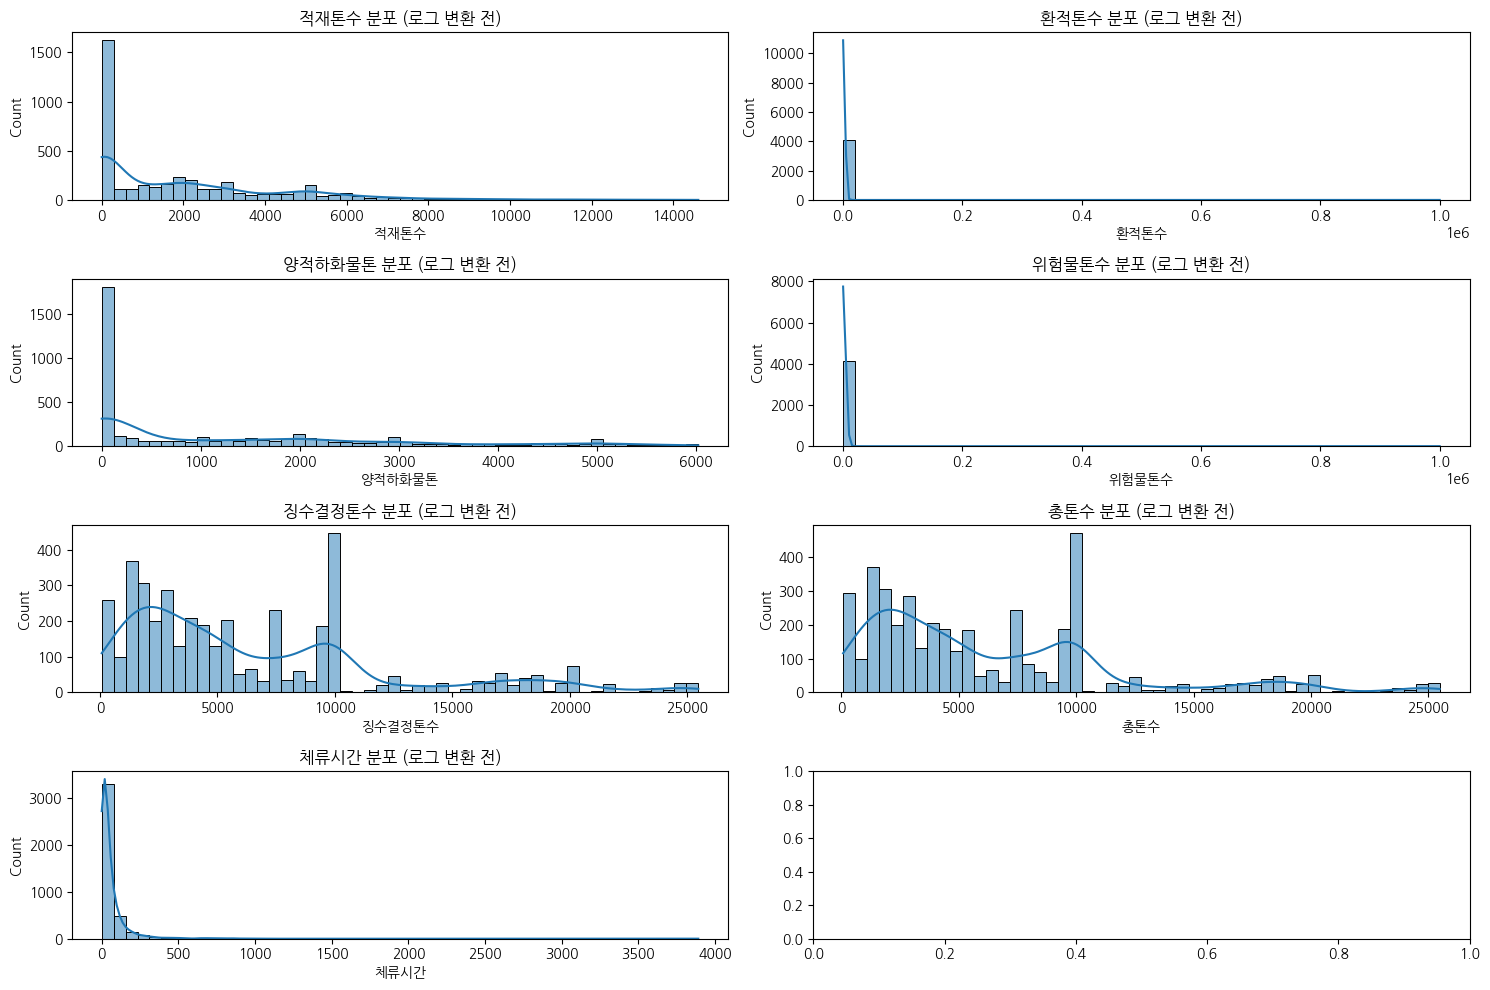

In [596]:
fig1, axes1 = plt.subplots(4, 2, figsize=(15, 10))
sns.histplot(df["적재톤수"], bins=50, kde=True, ax=axes1[0, 0]).set_title("적재톤수 분포 (로그 변환 전)")
sns.histplot(df["환적톤수"], bins=50, kde=True, ax=axes1[0, 1]).set_title("환적톤수 분포 (로그 변환 전)")
sns.histplot(df["양적하화물톤"], bins=50, kde=True, ax=axes1[1, 0]).set_title("양적하화물톤 분포 (로그 변환 전)")
sns.histplot(df["위험물톤수"], bins=50, kde=True, ax=axes1[1, 1]).set_title("위험물톤수 분포 (로그 변환 전)")
sns.histplot(df["징수결정톤수"], bins=50, kde=True, ax=axes1[2, 0]).set_title("징수결정톤수 분포 (로그 변환 전)")
sns.histplot(df["총톤수"], bins=50, kde=True, ax=axes1[2, 1]).set_title("총톤수 분포 (로그 변환 전)")
sns.histplot(df["체류시간"], bins=50, kde=True, ax=axes1[3, 0]).set_title("체류시간 분포 (로그 변환 전)")
plt.tight_layout()

이제 수치형 변수들에 대해 로그 변환을 수행하겠습니다. 로그 변환은 0 이하의 값이 있으면 적용이 불가능하므로 보통 `np.log1p()`를 써서 `log(1 + x)` 형태로 처리합니다.

In [597]:
numeric_cols = ["적재톤수", "환적톤수", "양적하화물톤", "위험물톤수", "징수결정톤수", "총톤수", "체류시간"]

for col in numeric_cols:
    df[col] = np.log1p(df[col])

변환된 수치형 변수의 분포를 히스토그램과 KDE로 살펴보겠습니다.

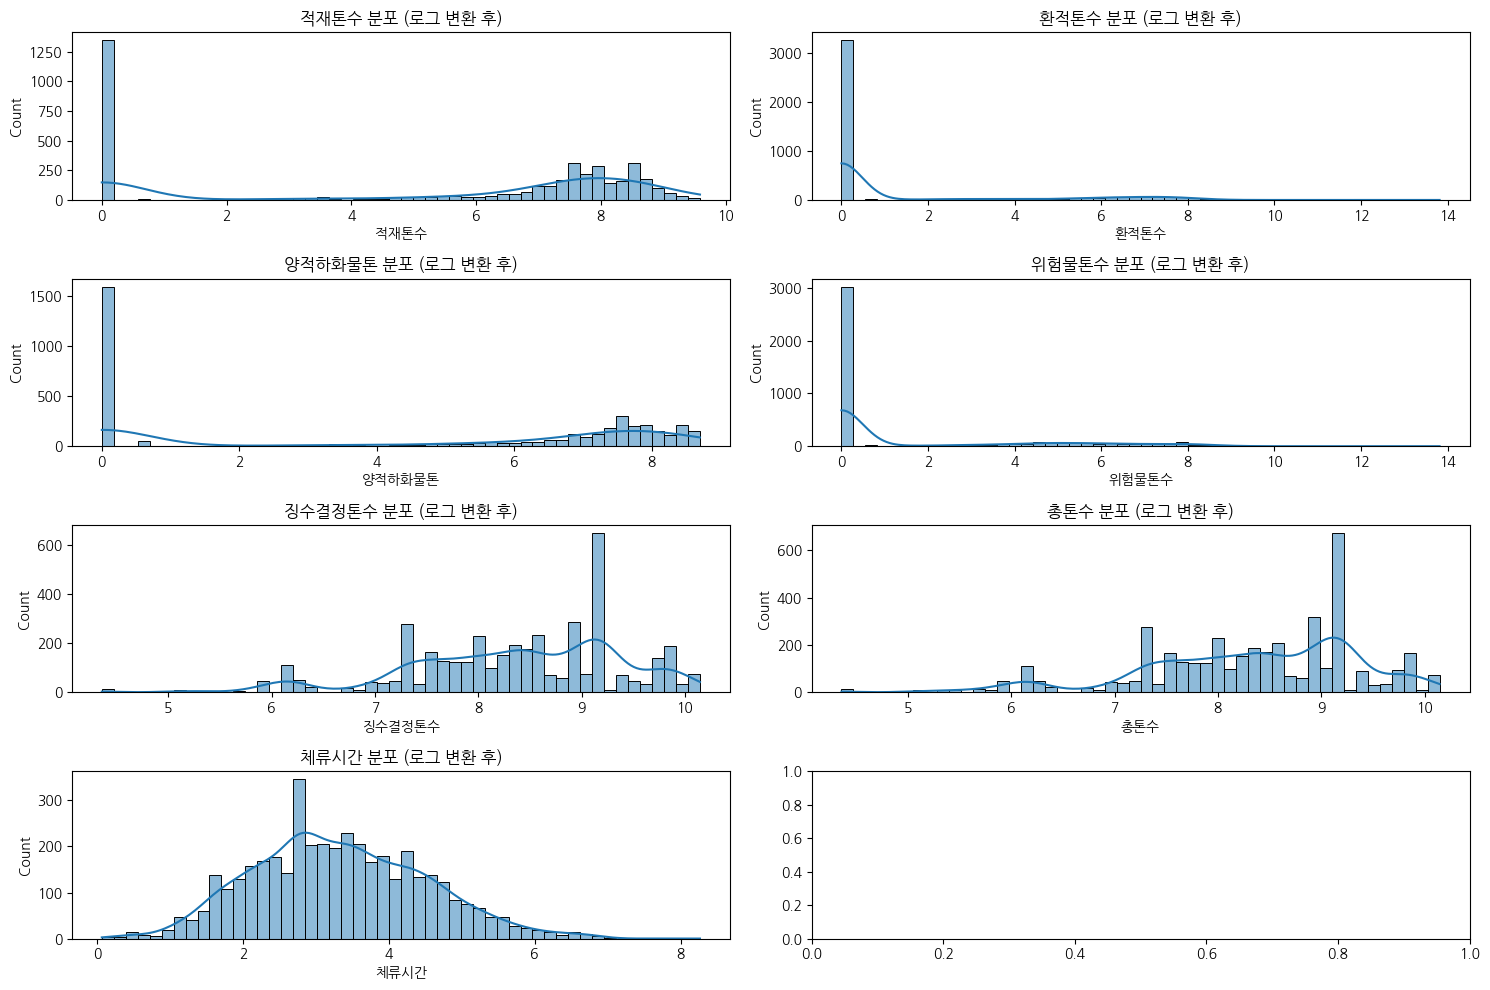

In [598]:
fig1, axes1 = plt.subplots(4, 2, figsize=(15, 10))
sns.histplot(df["적재톤수"], bins=50, kde=True, ax=axes1[0, 0]).set_title("적재톤수 분포 (로그 변환 후)")
sns.histplot(df["환적톤수"], bins=50, kde=True, ax=axes1[0, 1]).set_title("환적톤수 분포 (로그 변환 후)")
sns.histplot(df["양적하화물톤"], bins=50, kde=True, ax=axes1[1, 0]).set_title("양적하화물톤 분포 (로그 변환 후)")
sns.histplot(df["위험물톤수"], bins=50, kde=True, ax=axes1[1, 1]).set_title("위험물톤수 분포 (로그 변환 후)")
sns.histplot(df["징수결정톤수"], bins=50, kde=True, ax=axes1[2, 0]).set_title("징수결정톤수 분포 (로그 변환 후)")
sns.histplot(df["총톤수"], bins=50, kde=True, ax=axes1[2, 1]).set_title("총톤수 분포 (로그 변환 후)")
sns.histplot(df["체류시간"], bins=50, kde=True, ax=axes1[3, 0]).set_title("체류시간 분포 (로그 변환 후)")
plt.tight_layout()

기존 히스토그램과 비교했을 때 보다 정규분포에 가까운 형태로 바뀐 것을 볼 수 있습니다.

#### 스케일링

여러 변수 간 값의 <b>스케일(범위)</b>이 다르면 거리 기반 모델(KNN, SVM, 딥러닝 등) 또는 정규화가 필요한 알고리즘에서 문제 발생 가능성이 있습니다. 따라서 `StandardScaler`를 사용하여 수치형 변수를 표준화하도록 하겠습니다.

In [ ]:
#######################################################################################################################################
df
#######################################################################################################################################

,체류시간,적재톤수,환적톤수,양적하화물톤,위험물톤수,징수결정톤수,총톤수,화물_기타,화물_기타의비금속,화물_사료,화물_어류,"화물_연료,에너지",화물_유기화합물,화물_잡품,화물_철강,화물_철강제품,화물_해당없음
0,4.740575,3.135494,0.0,3.135494,0.0,5.318120,5.318120,False,False,False,True,False,False,False,False,False,False
1,4.494239,3.258097,0.0,3.258097,0.0,5.318120,5.318120,False,False,False,True,False,False,False,False,False,False
2,4.532599,3.258097,0.0,3.258097,0.0,5.318120,5.318120,False,False,False,True,False,False,False,False,False,False
3,5.214936,3.178054,0.0,3.178054,0.0,5.318120,5.318120,False,False,False,True,False,False,False,False,False,False
4,3.828641,3.295837,0.0,3.295837,0.0,5.318120,5.318120,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5638,3.255529,0.000000,0.0,0.000000,0.0,9.179056,9.179056,False,False,False,False,False,False,False,False,False,True
5639,3.639339,0.000000,0.0,0.000000,0.0,9.179056,9.179056,False,False,False,False,False,False,False,False,False,True
5643,3.591818,0.000000,0.0,0.000000,0.0,9.179056,9.179056,False,False,False,False,False,False,False,False,False,True
5644,3.558201,0.000000,0.0,0.000000,0.0,9.179056,9.179056,False,False,False,False,False,False,False,False,False,True


In [ ]:
# 스케일링
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
#######################################################################################################################################
df
#######################################################################################################################################

,체류시간,적재톤수,환적톤수,양적하화물톤,위험물톤수,징수결정톤수,총톤수,화물_기타,화물_기타의비금속,화물_사료,화물_어류,"화물_연료,에너지",화물_유기화합물,화물_잡품,화물_철강,화물_철강제품,화물_해당없음
0,1.189347,-0.515583,-0.482967,-0.325613,-0.553788,-2.929044,-2.857030,False,False,False,True,False,False,False,False,False,False
1,0.982405,-0.482374,-0.482967,-0.292013,-0.553788,-2.929044,-2.857030,False,False,False,True,False,False,False,False,False,False
2,1.014632,-0.482374,-0.482967,-0.292013,-0.553788,-2.929044,-2.857030,False,False,False,True,False,False,False,False,False,False
3,1.587848,-0.504055,-0.482967,-0.313949,-0.553788,-2.929044,-2.857030,False,False,False,True,False,False,False,False,False,False
4,0.423251,-0.472152,-0.482967,-0.281670,-0.553788,-2.929044,-2.857030,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5638,-0.058209,-1.364885,-0.482967,-1.184916,-0.553788,0.786684,0.818922,False,False,False,False,False,False,False,False,False,True
5639,0.264222,-1.364885,-0.482967,-1.184916,-0.553788,0.786684,0.818922,False,False,False,False,False,False,False,False,False,True
5643,0.224300,-1.364885,-0.482967,-1.184916,-0.553788,0.786684,0.818922,False,False,False,False,False,False,False,False,False,True
5644,0.196060,-1.364885,-0.482967,-1.184916,-0.553788,0.786684,0.818922,False,False,False,False,False,False,False,False,False,True


## 4. 체류 시간 예측 회귀 모델

모델링 단계에서는 화물 정보를 바탕으로 체류시간을 예측하는 회귀 모델을 구현해 보겠습니다. 사용하는 회귀 알고리즘은 랜덤 포레스트(`RandomForestRegressor`)입니다.

### 4.1. 데이터 분할

입력 변수(`X`)와 출력 변수(`y`)를 정의하고 학습용과 테스트용 데이터를 분할하겠습니다.

- 입력 변수 `X` : `체류시간` 컬럼을 제외한 나머지 컬럼
- 출력 변수 `y` : `체류시간` 컬럼

In [601]:
X = df.drop(columns=["체류시간"])
y = df["체류시간"]

`train_test_split()` 메서드를 사용하여 학습용, 테스트용 데이터를 분할하겠습니다.

이때 전체 데이터의 20%를 테스트용, 80%를 학습용으로 사용하고 랜덤 분할의 결과가 항상 동일하도록 시드를 **42**로 고정합니다.

# 맨 처음 14000 개 정도에서 3000개 남짓으로 줄었다.
# 굉장히 많이 날린 편. 
# 성능은 좋지 않을 것
최소 5000개 이상, 10000개 안팎이 되어야 해볼만

In [602]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("학습용 데이터 갯수 : ", len(X_train))
print("테스트용 데이터 갯수 : ", len(X_test))

학습용 데이터 갯수 :  3292
테스트용 데이터 갯수 :  824


### 4.2. 모델 학습

랜덤 포레스트 회귀 모델(`RandomForestRegressor`)을 사용하여 체류 시간 예측을 수행합니다. 이 모델은 여러 개의 결정 트리를 앙상블하여 예측 성능을 높이는 모델입니다.

100개의 결정 트리를 사용합니다. 결정 트리의 갯수는 클수록 안정적이지만 느려집니다. 또한 각 트리의 최대 깊이를 10으로 제한하여 과적합을 방지합니다.

In [603]:
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 5. 모델 검증

학습된 모델을 사용해 <b>테스트 데이터(X_test)</b>에 대한 체류시간을 예측하고 평가 지표를 통해 모델의 성능을 확인합니다.

테스트 데이터 `X_test`를 사용해 체류 시간을 예측합니다. 예측 결과는 `y_pred`에 저장됩니다.

In [604]:
y_pred = model.predict(X_test)

### 5.1. MSE (Mean Squared Error)

**MSE**는 평균 제곱 오차 (Mean Squared Error)의 약자로, 머신 러닝에서 회귀 모델의 성능을 평가하는 지표로 사용됩니다. 예측값과 실제값 사이의 차이를 제곱하여 평균낸 값으로, **값이 작을수록** 모델의 예측 정확도가 높음을 의미합니다. 

In [605]:
mse = mean_squared_error(y_test, y_pred)

print("MSE : ", mse)

MSE :  0.6284768045634092


### R² Score

**R² Score**는 결정계수를 의미하며 모델이 데이터의 분산을 얼마나 설명하는지 나타내는 지표입니다. 1에 가까울수록 우수한 성능을 나타내며 0이면 평균값 수준의 예측입니다. 음수일 경우 모델이 무작위 예측보다 못하다는 것을 의미합니다.

In [606]:
r2 = r2_score(y_test, y_pred)

print("R² Score:", r2)

R² Score: 0.34692952723685755


지금까지 진행한 데이터 분석, 전처리, 그리고 모델링 과정을 기반으로, 여러분만의 아이디어를 적용해 모델의 성능을 더욱 향상시켜 보세요. 예를 들어, 이상치 제거 기준을 바꾸거나, 새로운 파생변수를 생성하거나, 더 적합한 스케일링 기법을 선택하는 것도 좋은 방법입니다. 또한, 모델의 하이퍼파라미터를 조정하거나, 다른 머신러닝 알고리즘(XGBoost, Gradient Boosting 등)을 시도해 보는 것도 권장합니다.

여기서 중요한 점은 단순히 코드를 바꾸는 것이 아니라, **왜 그 방법이 더 효과적일 수 있는지** 논리적인 근거를 가지고 실험해보는 것입니다. 다양한 시도를 통해 결과를 비교하고, 성능이 얼마나 개선되었는지를 수치로 확인해 보세요. 이를 통해 여러분은 실제 데이터 기반 문제 해결에서 탐색적 사고와 실험적 접근의 중요성을 경험할 수 있습니다.

결국, 주어진 데이터를 어떻게 해석하고 다루느냐에 따라 예측 모델의 성능은 크게 달라질 수 있습니다. 창의적이고 분석적인 시도로 여러분만의 최적 모델을 찾아보시기 바랍니다.